In [ ]:
PreProcessing
- use a gpu method like GMM or kNN to assign nearest transactionid's ID column set
- add 3-4 clustering components. Ideally tSNE on a rich dataset...

CV
- ...

Postprocessing
- target encode: calculate cumsum over target (train) and over preds (test) / cumcount()
- if nothing after 120 records on GROUP (e.g. AccountID) then reset to 0


In [ ]:
# Technique 2:
# TODO: Group by Cat+Hour, then calculate Stats over Continuous

In [1]:
# import scipy.stats as spstats

# def build_gfeats(data):
#     # T1: Group by Cat, then calculate Stats over Continuous
#     def q90(x): return np.quantile(x, 0.90)
#     def q10(x): return np.quantile(x, 0.10)
#     aggs  = ['min','max','median','std', spstats.iqr, q90, q10]
#     conts = ['TransactionAmt', 'id_02', 'C13', 'D1_mfix', 'D15_mfix', 'dist1']
#     cats  = ['nulls_idn', 'nulls_trx', 'CardID', 'DeviceID', 'PAccountID', 'RAccountID']

#     for cat in cats:
#         for cont in tqdm(conts):
#             temp = data.groupby(cat)[cont].agg(aggs)
#             temp.columns = ['G{}_{}_{}'.format(cat, cont, col) for col in ['min','max','median','std','iqr','q90','q10']]
#             data = data.merge(temp, how='left', on=cat)

#     return data

In [3]:
import pandas as pd
import numpy as np
from time import time
import datetime
import lightgbm as lgb
import gc
gc.collect()

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_score, recall_score, confusion_matrix, accuracy_score
from sklearn.metrics import roc_auc_score, f1_score, roc_curve, auc,precision_recall_curve
from scipy import interp
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [4]:
traintr = pd.read_csv('input/train_transaction.csv.zip')
trainid = pd.read_csv('input/train_identity.csv.zip')

testtr = pd.read_csv('input/test_transaction.csv.zip')
testid = pd.read_csv('input/test_identity.csv.zip')

# Nan Structure Investigation

In [195]:
nulltr = bothtr[[c for c in bothtr if c != 'isFraud']].isnull().sum().sort_values().reset_index()
nulltr.rename(columns={'index':'col', 0:'nulls'}, inplace=True)
grouped_tr = nulltr.groupby('nulls').col.agg(list).reset_index()
grouped_tr

,nulls,col
0,0,"[index, TransactionID, TransactionDT, Transact..."
1,3,"[C4, C5, C6, C7, C11, C10, C3, C12, C14, C9, C..."
2,15,"[V286, V320, V319, V318, V317, V316, V312, V31..."
3,314,"[V124, V118, V119, V120, V121, V122, V123, V12..."
4,4567,[card3]
5,4578,[card6]
6,4663,[card4]
7,4748,[C13]
8,7300,"[V301, V300, V296, V315, V314, V313, V289, V28..."
9,8806,[card5]


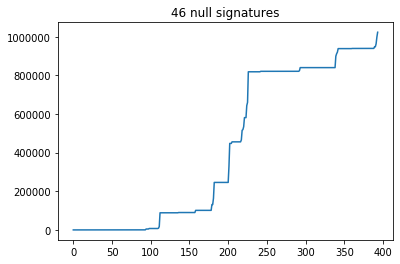

In [167]:
plt.title('{} null signatures'.format(nulltr.nunique()))
plt.plot(nulltr.values)
plt.show()

One idea here being that if two records share the same null-structure, they potentially could be part of the same group. Our first level of grouping is based on concatenating all of the cardN columns. These nullable columns can act as further grouping.

# EDA On Non-Categorical vars that seem like they should me

**Categorical Vars**

Trans
- ProductCD
- card1 - card6
- addr1, addr2
- P_emaildomain
- R_emaildomain
- M1 - M9

ID
- DeviceType
- DeviceInfo
- id_12 - id_38

**Continuous Vars**
- TransactionDT
- TransactionAmt
- dist1
- dist2
- C1-C14
- D1-D15
- V1-V339

In [5]:
cat = [
    'ProductCD',
    'card1','card2','card3','card4','card5','card6',
    'addr1','addr2',
    'P_emaildomain','R_emaildomain',
    'M1','M2','M3','M4','M5','M6','M7','M8','M9',
]

In [6]:
nunique_col = bothtr[[c for c in bothtr.columns if c not in cat]].nunique()
nunique_col.sort_values().head()

V107                    2
isFraud                 2
V14                     2
V1                      2
V88                     2
V41                     2
V65                     2
V305                    2
V94                     3
V119                    4
V118                    4
V117                    4
V35                     5
V12                     5
V120                    5
V121                    5
V122                    5
V241                    6
V53                     6
V69                     6
V29                     6
V48                     6
V21                     6
V10                     6
V75                     6
V90                     6
V71                     7
V13                     7
V141                    7
V36                     7
                   ...   
V273                12865
V211                13031
V133                13668
V275                14143
V213                14582
V316                14984
V274                15111
V126        

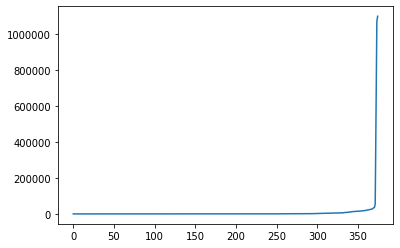

In [187]:
plt.plot(nunique_col.sort_values().values)
plt.show()

Can we look into value counts for these? Perhaps even though they are continuous, the counts of how many times certain values appear, especially across nan-groups, can give us good info!

**Santander**

If I have a categorical variable `X`, ML can learn `p(y | x)` for some `x` in `X`; but it can't learn things related to count, such as `p(y | n_x)` where `n` is the frequency that elements in the training set take on the category `x`.

In [207]:
# We can use techniques like these to pull out 'high mean - high size' items
# Create a list of them, and use FI on them while keeping the rest of the features
# LGBM will take high cardinality continuous values and bin them with equisized bins
# By pulling put certain common-sense high-mean values ($150, $25, $200, $75, $300,  $40, $250, $60)
# etc, and creating conglamorate features out of them... then letting LightGBM take care of
# the rest via built-in binning, we can extract more detailed information.

# We can also use value counts transformation on each column, then sum them up, as a means
# of seeing how 'weird' a transaction is... try this on both categorical and continuous vars
traintr.groupby('V335').isFraud.agg(['size','mean']).sort_values('size', ascending=False)

,size,mean
V335,,
0.0,72668,0.043307
2301.0,925,0.000000
100.0,835,0.033533
50.0,809,0.033375
150.0,426,0.086854
25.0,398,0.040201
1259.0,326,0.000000
200.0,315,0.085714
30.0,254,0.027559


# Start

In [18]:
import logging
from typing import Optional

import numpy as np
from sklearn.model_selection._split import _BaseKFold
from sklearn.utils import indexable
from sklearn.utils.validation import _num_samples

LOGGER = logging.getLogger(__name__)

class TimeSeriesSplit(_BaseKFold):  # pylint: disable=abstract-method
    # https://www.kaggle.com/mpearmain/extended-timeseriessplitter
    """Time Series cross-validator

    Provides train/test indices to split time series data samples that are observed at fixed time intervals,
    in train/test sets. In each split, test indices must be higher than before, and thus shuffling in cross validator is
    inappropriate.

    This cross_validation object is a variation of :class:`TimeSeriesSplit` from the popular scikit-learn package.
    It extends its base functionality to allow for expanding windows, and rolling windows with configurable train and
    test sizes and delays between each. i.e. train on weeks 1-8, skip week 9, predict week 10-11.

    In this implementation we specifically force the test size to be equal across all splits.

    Expanding Window:

            Idx / Time  0..............................................n
            1           |  train  | delay |  test  |                   |
            2           |       train     | delay  |  test  |          |
            ...         |                                              |
            last        |            train            | delay |  test  |

    Rolling Windows:
            Idx / Time  0..............................................n
            1           | train   | delay |  test  |                   |
            2           | step |  train  | delay |  test  |            |
            ...         |                                              |
            last        | step | ... | step |  train  | delay |  test  |

    Parameters:
        n_splits : int, default=5
            Number of splits. Must be at least 4.

        train_size : int, optional
            Size for a single training set.

        test_size : int, optional, must be positive
            Size of a single testing set

        delay : int, default=0, must be positive
            Number of index shifts to make between train and test sets
            e.g,
            delay=0
                TRAIN: [0 1 2 3] TEST: [4]
            delay=1
                TRAIN: [0 1 2 3] TEST: [5]
            delay=2
                TRAIN: [0 1 2 3] TEST: [6]

        force_step_size : int, optional
            Ignore split logic and force the training data to shift by the step size forward for n_splits
            e.g
            TRAIN: [ 0  1  2  3] TEST: [4]
            TRAIN: [ 0  1  2  3  4] TEST: [5]
            TRAIN: [ 0  1  2  3  4  5] TEST: [6]
            TRAIN: [ 0  1  2  3  4  5  6] TEST: [7]
    
    Examples
    --------
    >>> X = np.array([[1, 2], [3, 4], [1, 2], [3, 4], [1, 2], [3, 4]])
    >>> y = np.array([1, 2, 3, 4, 5, 6])
    >>> tscv = TimeSeriesSplit(n_splits=5)
    >>> print(tscv)  # doctest: +NORMALIZE_WHITESPACE
    TimeSeriesSplit(train_size=None, n_splits=5)
    >>> for train_index, test_index in tscv.split(X):
    ...    print('TRAIN:', train_index, 'TEST:', test_index)
    ...    X_train, X_test = X[train_index], X[test_index]
    ...    y_train, y_test = y[train_index], y[test_index]
    TRAIN: [0] TEST: [1]
    TRAIN: [0 1] TEST: [2]
    TRAIN: [0 1 2] TEST: [3]
    TRAIN: [0 1 2 3] TEST: [4]
    TRAIN: [0 1 2 3 4] TEST: [5]
    """

    def __init__(self,
                 n_splits: Optional[int] = 5,
                 train_size: Optional[int] = None,
                 test_size: Optional[int] = None,
                 delay: int = 0,
                 force_step_size: Optional[int] = None):

        if n_splits and n_splits < 5:
            raise ValueError(f'Cannot have n_splits less than 5 (n_splits={n_splits})')
        super().__init__(n_splits, shuffle=False, random_state=None)

        self.train_size = train_size

        if test_size and test_size < 0:
            raise ValueError(f'Cannot have negative values of test_size (test_size={test_size})')
        self.test_size = test_size

        if delay < 0:
            raise ValueError(f'Cannot have negative values of delay (delay={delay})')
        self.delay = delay

        if force_step_size and force_step_size < 1:
            raise ValueError(f'Cannot have zero or negative values of force_step_size '
                             f'(force_step_size={force_step_size}).')

        self.force_step_size = force_step_size

    def split(self, X, y=None, groups=None):
        """Generate indices to split data into training and test set.

        Parameters:
            X : array-like, shape (n_samples, n_features)
                Training data, where n_samples is the number of samples  and n_features is the number of features.

            y : array-like, shape (n_samples,)
                Always ignored, exists for compatibility.

            groups : array-like, with shape (n_samples,), optional
                Always ignored, exists for compatibility.

        Yields:
            train : ndarray
                The training set indices for that split.

            test : ndarray
                The testing set indices for that split.
        """
        X, y, groups = indexable(X, y, groups)  # pylint: disable=unbalanced-tuple-unpacking
        n_samples = _num_samples(X)
        n_splits = self.n_splits
        n_folds = n_splits + 1
        delay = self.delay

        if n_folds > n_samples:
            raise ValueError(f'Cannot have number of folds={n_folds} greater than the number of samples: {n_samples}.')

        indices = np.arange(n_samples)
        split_size = n_samples // n_folds

        train_size = self.train_size or split_size * self.n_splits
        test_size = self.test_size or n_samples // n_folds
        full_test = test_size + delay

        if full_test + n_splits > n_samples:
            raise ValueError(f'test_size\\({test_size}\\) + delay\\({delay}\\) = {test_size + delay} + '
                             f'n_splits={n_splits} \n'
                             f' greater than the number of samples: {n_samples}. Cannot create fold logic.')

        # Generate logic for splits.
        # Overwrite fold test_starts ranges if force_step_size is specified.
        if self.force_step_size:
            step_size = self.force_step_size
            final_fold_start = n_samples - (train_size + full_test)
            range_start = (final_fold_start % step_size) + train_size

            test_starts = range(range_start, n_samples, step_size)

        else:
            if not self.train_size:
                step_size = split_size
                range_start = (split_size - full_test) + split_size + (n_samples % n_folds)
            else:
                step_size = (n_samples - (train_size + full_test)) // n_folds
                final_fold_start = n_samples - (train_size + full_test)
                range_start = (final_fold_start - (step_size * (n_splits - 1))) + train_size

            test_starts = range(range_start, n_samples, step_size)

        # Generate data splits.
        for test_start in test_starts:
            idx_start = test_start - train_size if self.train_size is not None else 0
            # Ensure we always return a test set of the same size
            if indices[test_start:test_start + full_test].size < full_test:
                continue
            yield (indices[idx_start:test_start],
                   indices[test_start + delay:test_start + full_test])
            

In [19]:
def examine_feature(feature='P_emaildomain'):
    global traintr, bothtr

    look = bothtr.groupby(feature).size().reset_index()
    look.rename(columns={0:'fullsize'}, inplace=True)
    temp = traintr.groupby(feature).isFraud.agg(['size','mean']).sort_values('mean').reset_index()
    temp.rename(columns={'size':'trsize', 'mean':'isFraud'}, inplace=True)
    look = look.merge(temp, how='left', on=feature)
    
    print(feature, 'num unique vals:', look[feature].nunique())
    return look

In [26]:
def build_ranges(ranges):
    out = []
    for arange in ranges:
        out.append(np.arange(arange[0], arange[-1]+1, 1).tolist())
    return sum(out, [])
    
def target_mean_encode(data, col):
    encode = data.groupby(col).isFraud.mean().sort_values(ascending=False).reset_index()
    mapper = {k:v for v, k in enumerate(encode[col].values)}
    data[col] = data[col].map(mapper)
    return data, mapper

tt = time()
def updateme(msg, reset=False):
    global tt
    if reset: tt = time()
    print(time()-tt, msg)
    tt = time()

def build_features(trx,idn):
    updateme('Mergind DFrame + Computing NANs')
    trx['nulls_trx'] = trx.isna().sum(axis=1)
    idn['nulls_idn'] = idn.isna().sum(axis=1)

    data = trx.merge(idn, how='left', on='TransactionID')
    old_features = [c for c in data.columns if c not in ['nulls_trx', 'nulls_idn']]
    
    # Make sure everything is lowercase
    for c1, c2 in data.dtypes.reset_index().values:
        if not c2=='O': continue
        data[c1] = data[c1].astype(str).apply(str.lower)
    
    updateme('Building Groups')
    stringy = lambda x: x.astype(str) + ' '
    data['CardID'] = stringy(data.card1) + stringy(data.card2) + stringy(data.card3) + stringy(data.card4) + stringy(data.card5) + stringy(data.card6) \
    + stringy(data.addr1) # + stringy(data.addr2) # Sergey says addr1 only: https://www.kaggle.com/c/ieee-fraud-detection/discussion/101785#latest-588573
    data['DeviceID']  = stringy(data.DeviceType) + stringy(data.DeviceInfo) + stringy(data.id_31) # TODO: Clean
    data['PAccountID'] = stringy(data.addr1) + stringy(data.addr2) + stringy(data.P_emaildomain)
    data['RAccountID'] = stringy(data.addr1) + stringy(data.addr2) + stringy(data.R_emaildomain)

    updateme('Count Encoding Groups')
    # TODO: Try count + label encode (e.g. both)
    for col in ['nulls_idn', 'nulls_trx', 'CardID', 'DeviceID', 'PAccountID', 'RAccountID', 'ProductCD']:
        data[col] = data[col].map(data[col].value_counts(dropna=False))
    
    updateme('Count Encoding Vars')
    count_encode = ['card1', 'id_34', 'id_36', 'TransactionAmt']
    for col in count_encode:
        data['CountEncode_' + col] = data[col].map(data[col].value_counts(dropna=False))
        
        
    updateme('Email Features')
    data['TransactionAmtCents'] = np.ceil(data.TransactionAmt) - np.floor(data.TransactionAmt)
    country_map = {
        'com':'us', 'net':'us', 'edu':'us', 'gmail':'us', 
        'mx': 'mx', 'es':'es', 'de':'de', 'fr':'fr',
        'uk':'uk', 'jp':'jp'
    }
    domain = lambda x: x.split('.')[0]
    pemail_country = lambda x: x.split('.')[-1]
    data['pemail_domain']  = data.P_emaildomain.astype(str).apply(domain)
    data['pemail_ext']     = data.P_emaildomain.astype(str).apply(pemail_country).map(country_map)
    data['remail_domain']  = data.R_emaildomain.astype(str).apply(domain)
    data['remail_ext']     = data.R_emaildomain.astype(str).apply(pemail_country).map(country_map)
    data['p_and_r_email']  = data.P_emaildomain.astype(str) + ' ' + data.R_emaildomain.astype(str)

    updateme('Time Features')
    # We can calculate transaction hour directly;
    # But samples where D9 isna seem to have less fraud rate. And there's a LOT of them:
    data.D9 = data.D9.isnull()
    
    # Time deltas Mod7 and mod(7*4)
    for i in range(1,16):
        if i in [8,9]: continue
        temp = data['D'+str(i)] % 7
        temp.loc[data['D'+str(i)]==0] = -1
        data['D{}_mod7'.format(i)] = temp.values
    
    slope = 1 / (60*60*24) # sec/day
    for i in range(1,16):
        if i in [9]: continue
        feature = 'D' + str(i)
        data[feature+'_mfix'.format(i)] = np.round_(data[feature] - (data.TransactionDT - data.TransactionDT.min()) * slope)
        data[feature+'_mfix_mod7'.format(i)] = data[feature+'_mfix'.format(i)] % 7
        
    START_DATE     = '2017-12-01'
    startdate      = datetime.datetime.strptime(START_DATE, '%Y-%m-%d')
    data['tdt']    = data['TransactionDT'].apply(lambda x: (startdate + datetime.timedelta(seconds = x)))
    data['tdow']   = data.tdt.dt.dayofweek
    data['thour']  = data.tdt.dt.hour
    data['tdate']  = data.tdt.dt.date
    
    
    # TODO: Add holidays.
    
    # @9h, id_01 is the least
    # @18h, id_02 is the least
    data['thour_id_01'] = ((np.abs(9 - data.thour) % 12) + 1) * (data.id_01 + 1)
    data['thour_id_02'] = ((np.abs(18 - data.thour) % 12) + 1) * (data.id_02 + 1)
    
    # Groups:
    updateme('Group Aggregates')
    # I'm also trying features like HourTransactionVolume, DayTransactionVolume, etc, but they are not very promising. They tend to increase cv, but decreases lb. I hope this inspires you.
    # temp = data.groupby(['thour','tdate']).size().reset_index()
    # temp.rename(columns={0:'trans_per_hourdate'}, inplace=True)
    # data = data.merge(temp, how='left', on=['thour','tdate'])
    
    temp = data.groupby('thour').size().reset_index()
    temp.rename(columns={0:'trans_per_hour'}, inplace=True)
    data = data.merge(temp, how='left', on='thour')
                  
    cat = 'CardID'
    grp = data.groupby(cat)
    temp = grp.id_02.agg(['min','std'])
    temp.columns = ['G{}_{}_{}'.format(cat, 'id_02', col) for col in ['min','std']]
    data = data.merge(temp, how='left', on=cat)
    
    temp = grp.C13.agg(['std'])
    temp.columns = ['G{}_{}_{}'.format(cat, 'C13', col) for col in ['std']]
    data = data.merge(temp, how='left', on=cat)
    
    temp = grp.TransactionAmt.agg(['max'])
    temp.columns = ['G{}_{}_{}'.format(cat, 'TransactionAmt', col) for col in ['max']]
    data = data.merge(temp, how='left', on=cat)
    
    temp = grp.D1_mfix.agg(['max'])
    temp.columns = ['G{}_{}_{}'.format(cat, 'D1_mfix', col) for col in ['max']]
    data = data.merge(temp, how='left', on=cat)

    cat = 'PAccountID'
    grp = data.groupby(cat)
    temp = grp.dist1.agg(['max', 'std'])
    temp.columns = ['G{}_{}_{}'.format(cat, 'dist1', col) for col in ['max', 'std']]
    data = data.merge(temp, how='left', on=cat)

    cat = 'nulls_trx'
    grp = data.groupby(cat)
    temp = grp.id_02.agg(['max'])
    temp.columns = ['G{}_{}_{}'.format(cat, 'id_02', col) for col in ['max']]
    data = data.merge(temp, how='left', on=cat)
    
    temp = grp.C13.agg(['max'])
    temp.columns = ['G{}_{}_{}'.format(cat, 'C13', col) for col in ['max']]
    data = data.merge(temp, how='left', on=cat)
    
    cat = 'thour'
    temp = data.groupby(cat).TransactionAmt.agg(['min','max','mean','median','std'])
    temp.columns = ['G{}_{}_{}'.format(cat, 'TransactionAmt', col) for col in ['min','max','mean','median','std']]
    data = data.merge(temp, how='left', on=cat)
                    
    cat = 'addr1'
    temp = data.groupby(cat).TransactionAmt.agg(['min','max','mean','median','std'])
    temp.columns = ['G{}_{}_{}'.format(cat, 'TransactionAmt', col) for col in ['min','max','mean','median','std']]
    data = data.merge(temp, how='left', on=cat)
                    
    cat = 'card5'
    temp = data.groupby(cat).TransactionAmt.agg(['min','max','mean','median','std'])
    temp.columns = ['G{}_{}_{}'.format(cat, 'TransactionAmt', col) for col in ['min','max','mean','median','std']]
    data = data.merge(temp, how='left', on=cat)
                    
    # End Groups
    
    # IDEA here is (proven garbage with M5 and D1):
    # Access from outside your country. (IP and browser language settings, time zone) (M? x D? interactions)
    #data['M5_D1_mfix'] = (data.M5.map({'F':2, 'T':1, np.nan:0})+1).astype(np.float) * (data.D1_mfix-data.D1_mfix.min()+1).astype(np.float)
    
    updateme('OHEs...')
    # These just have fun isFraud means
    OHEFeatures = {
        'P_emaildomain': 'protonmail.com',
        'R_emaildomain': 'protonmail.com',
        'card2': 176,
        #'addr2': 65,
        #'V283': 17,
        #'V37': 8,
        #'V45': 4,
    }
    for key, val in OHEFeatures.items(): data['OHE_'+key] = data[key]==val

    # During labeling the categorical values, protonmail.com tends to come up in others. Instead use this as another label. This gained me +0.120.
    
    
    # addr1, addr2 <-- something in there. Also look at dist1 with these
    # dist1 is probably dist from last transaction location
    
    # These guys have the SAME value_count distribution per key as well!
    # V126-V137 looks interesting. maybe a dollar amount or a distance
    # V160-V166 similar to above
    # V202-V206 similar
    # V207-V216 similar
    # V263-V278 similar
    # V306-V321 similar
    # V331-V339 similar
    cols = ['V' + str(col) for col in build_ranges([
        [126,137],
        [160,166],
        [202,216],
        [263,278],
        [306,321],
        [331,339],
    ])]
    
    #traintr['VSUM1'] = traintr.V130+traintr.V133+traintr.V136
    #data['dollar_weirdness'] = data[cols].apply(lambda x: np.unique(x).shape[0], axis=1)
    #data['weirdness'] = data[continuous].apply(lambda x: np.unique(x).shape[0], axis=1)
    
    # V167-V168, V170 has similar distro
    # V153-V158
    
    
#     # Mean value of random columns belonging to samples we misclassify
#     # Pred=0, Actual=1
#     badguy = {
#         'TransactionAmt':    175.132982,
#         'C1':                 26.855532,
#         'C2':                 31.275574,
#         'D1':                 30.312290,
#         'D2':                 91.129977,
#         'V100':                0.107696,
#         'V310':               36.764886,
#     }
#     for key,val in badguy.items():
#         data['BGuy_'+key] = data[key] - val

    # Interaction
    updateme('Interactions')
    interactions = [['addr1','card1'], ['card1','card5'],
                    ['C5','C9'], ['C5','C13'],['C5','C14'],['C13','C14']]
    for a,b in interactions:
        data[a + '_x_' + b] = stringy(data[a]) + stringy(data[b])
        data[a + '_*_' + b] = (data[a] * data[b])
    
    
    del data['tdt'], data['tdate']
    new_features = list(set(data.columns) - set(old_features))
    data.reset_index(drop=True, inplace=True)
    
    return data, new_features

In [28]:
gc.collect()

trx_size = traintr.shape[0]
trans    = traintr.append(testtr, sort=False)
ids      = trainid.append(testid, sort=False)
trans.reset_index(drop=True, inplace=True)
ids.reset_index(drop=True, inplace=True)

data, new_features = build_features(trans, ids)

new_features   = [f for f in data.columns if f not in ['TransactionDT', 'TransactionID']]
train_features = [f for f in new_features if f not in ['isFraud']]

gc.collect()

15.280424118041992 Mergind DFrame + Computing NANs
22.990751028060913 Building Groups
3.581812858581543 Count Encoding Groups
0.6503579616546631 Count Encoding Vars
0.2554445266723633 Email Features
1.4309179782867432 Time Features
1.5291919708251953 Group Aggregates
376.97635555267334 OHEs...
0.050414323806762695 Interactions


394

In [35]:
# # TODO: CountEncode appropriate vars
# count_encode = ['CardID', 'p_and_r_email', 'remail_domain', 'pemail_ext', 'remail_ext', 'pemail_domain']
# for col in tqdm(count_encode):
#     data[col] = data[col].map(data[col].value_counts(dropna=False))
    
# LabelEncode
le = LabelEncoder()
le_features = []
for col in tqdm(new_features):
    if data[col].dtype != 'object': continue
        
    # Keep Nans Nan:
    le_features.append(col)
    mapper = {key:val for val,key in enumerate(data[col].unique())}
    if np.nan in mapper: mapper[np.nan] = np.nan
    data[col] = data[col].map(mapper)
    
le_features

100%|██████████| 533/533 [00:05<00:00, 98.65it/s]


['ProductCD',
 'card4',
 'card6',
 'P_emaildomain',
 'R_emaildomain',
 'M1',
 'M2',
 'M3',
 'M4',
 'M5',
 'M6',
 'M7',
 'M8',
 'M9',
 'id_12',
 'id_15',
 'id_16',
 'id_23',
 'id_27',
 'id_28',
 'id_29',
 'id_30',
 'id_31',
 'id_33',
 'id_34',
 'id_35',
 'id_36',
 'id_37',
 'id_38',
 'DeviceType',
 'DeviceInfo',
 'pemail_domain',
 'pemail_ext',
 'remail_domain',
 'remail_ext',
 'p_and_r_email',
 'addr1_x_card1',
 'card1_x_card5',
 'C5_x_C9',
 'C5_x_C13',
 'C5_x_C14',
 'C13_x_C14']

In [29]:
data['noise0'] = np.random.normal(size=data.shape[0])
data['noise1'] = np.random.uniform(size=data.shape[0])
train_features += ['noise0','noise1']

In [36]:
data_trn = data.iloc[:trx_size]
data_sub = data.iloc[trx_size:]

In [32]:
# Confusion matrix 
def plot_confusion_matrix(
    cm,
    classes,
    normalize = False,
    title = 'Confusion matrix"',
    cmap = plt.cm.Blues
):
    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 0)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])) :
        plt.text(j, i, cm[i, j],
                 horizontalalignment = 'center',
                 color = 'white' if cm[i, j] > thresh else 'black')
 
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Stratified Val


fold 1
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.99924	valid_1's auc: 0.970921
[200]	training's auc: 0.999998	valid_1's auc: 0.973922
[300]	training's auc: 1	valid_1's auc: 0.974195
Early stopping, best iteration is:
[258]	training's auc: 1	valid_1's auc: 0.974381

fold 2
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.999173	valid_1's auc: 0.972708
[200]	training's auc: 0.999998	valid_1's auc: 0.976608
[300]	training's auc: 1	valid_1's auc: 0.977133
Early stopping, best iteration is:
[283]	training's auc: 1	valid_1's auc: 0.977066

fold 3
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.999243	valid_1's auc: 0.970981
[200]	training's auc: 0.999999	valid_1's auc: 0.975795
[300]	training's auc: 1	valid_1's auc: 0.976179
[400]	training's auc: 1	valid_1's auc: 0.976245
Early stopping, best iteration is:
[304]	training's auc: 1	valid_1's auc: 0.97617

fold 4
Training u

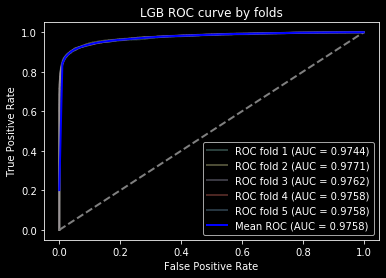

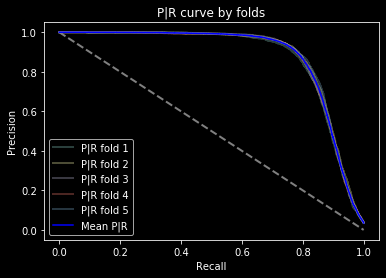

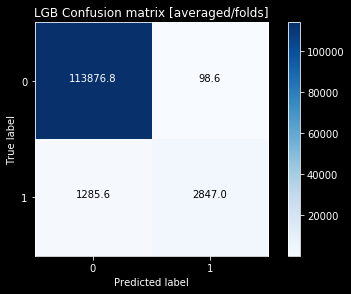

In [162]:
params = {'num_leaves': 32, #491,
          #'min_child_weight': 0.03454472573214212,
          #'feature_fraction': 0.3797454081646243,
          #'bagging_fraction': 0.4181193142567742,
          #'min_data_in_leaf': 106,
          'objective': 'binary',
          'max_depth': -1,
          'learning_rate': 0.01,
          "boosting_type": "gbdt",
          "bagging_seed": 11,
          "metric": 'auc',
          "verbosity": -1,
          #'reg_alpha': 0.3899927210061127,
          #'reg_lambda': 0.6485237330340494,
          'random_state': 47
}

param_lgb = {
    'bagging_fraction': 0.90,
    'feature_fraction': 0.90,
    'max_depth': 50,
    'min_child_weight': 0.0029805017044362268,
    'min_data_in_leaf': 20,
    'num_leaves': 382,
    'reg_alpha': 1,
    'reg_lambda': 2,

#     'min_data_in_leaf': int(LGB_BO.max['params']['min_data_in_leaf']), 
#     'num_leaves': int(LGB_BO.max['params']['num_leaves']), 
#     #'learning_rate': LGB_BO.max['params']['learning_rate'],
#     'min_child_weight': LGB_BO.max['params']['min_child_weight'],
#     'bagging_fraction': LGB_BO.max['params']['bagging_fraction'], 
#     'feature_fraction': LGB_BO.max['params']['feature_fraction'],
#     'reg_lambda': LGB_BO.max['params']['reg_lambda'],
#     'reg_alpha': LGB_BO.max['params']['reg_alpha'],
#     'max_depth': int(LGB_BO.max['params']['max_depth']), 
    
    'objective': 'binary',
    'save_binary': True,
    'seed': 1337,
    'feature_fraction_seed': 1337,
    'bagging_seed': 1337,
    'drop_seed': 1337,
    'data_random_seed': 1337,
    'boosting_type': 'gbdt',
    'verbose': 1,
    'is_unbalance': False,
    'boost_from_average': True,
    'metric':'auc'
}

features = train_features.copy()
target = 'isFraud'

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold,KFold
# from bayes_opt import BayesianOptimization
from sklearn.metrics import precision_score, recall_score, confusion_matrix, accuracy_score, roc_auc_score, f1_score, roc_curve, auc,precision_recall_curve
from scipy import interp
import itertools

train_df = data_trn.copy()
test_df = data_sub.copy()

nfold = 5
skf = StratifiedKFold(n_splits=nfold, shuffle=True, random_state=42)

oof = np.zeros(len(train_df))
mean_fpr = np.linspace(0,1,100)
cms= []
tprs = []
aucs = []
y_real = []
y_proba = []
recalls = []
roc_aucs = []
f1_scores = []
accuracies = []
precisions = []
predictions = np.zeros(len(test_df))
feature_importance_df = pd.DataFrame()

i = 1
for train_idx, valid_idx in skf.split(train_df, train_df.isFraud.values):
    print("\nfold {}".format(i))
    trn_data = lgb.Dataset(
        train_df.iloc[train_idx][features].values,
        label=train_df.iloc[train_idx][target].values
    )
    val_data = lgb.Dataset(
        train_df.iloc[valid_idx][features].values,
        label=train_df.iloc[valid_idx][target].values
    )
    
    clf = lgb.train(param_lgb, trn_data, num_boost_round = 500, valid_sets = [trn_data, val_data], verbose_eval = 100, early_stopping_rounds = 100)
    oof[valid_idx] = clf.predict(train_df.iloc[valid_idx][features].values) 
    
    predictions += clf.predict(test_df[features]) / nfold
    
    # Scores
    roc_aucs.append(roc_auc_score(train_df.iloc[valid_idx][target].values, oof[valid_idx]))
    accuracies.append(accuracy_score(train_df.iloc[valid_idx][target].values, oof[valid_idx].round()))
    recalls.append(recall_score(train_df.iloc[valid_idx][target].values, oof[valid_idx].round()))
    precisions.append(precision_score(train_df.iloc[valid_idx][target].values ,oof[valid_idx].round()))
    f1_scores.append(f1_score(train_df.iloc[valid_idx][target].values, oof[valid_idx].round()))
    
    # Roc curve by folds
    f = plt.figure(1)
    fpr, tpr, t = roc_curve(train_df.iloc[valid_idx][target].values, oof[valid_idx])
    tprs.append(interp(mean_fpr, fpr, tpr))
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=2, alpha=0.3, label='ROC fold %d (AUC = %0.4f)' % (i,roc_auc))
    
    # Precion recall by folds
    g = plt.figure(2)
    precision, recall, _ = precision_recall_curve(train_df.iloc[valid_idx][target].values, oof[valid_idx])
    y_real.append(train_df.iloc[valid_idx][target].values)
    y_proba.append(oof[valid_idx])
    plt.plot(recall, precision, lw=2, alpha=0.3, label='P|R fold %d' % (i))  
    
    i += 1
    
    # Confusion matrix by folds
    cms.append(confusion_matrix(train_df.iloc[valid_idx][target].values, oof[valid_idx].round()))
    
    # Features imp
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = nfold + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

# Metrics
print(
    '\nCV roc score        : {0:.4f}, std: {1:.4f}.'.format(np.mean(roc_aucs), np.std(roc_aucs)),
    '\nCV accuracy score   : {0:.4f}, std: {1:.4f}.'.format(np.mean(accuracies), np.std(accuracies)),
    '\nCV recall score     : {0:.4f}, std: {1:.4f}.'.format(np.mean(recalls), np.std(recalls)),
    '\nCV precision score  : {0:.4f}, std: {1:.4f}.'.format(np.mean(precisions), np.std(precisions)),
    '\nCV f1 score         : {0:.4f}, std: {1:.4f}.'.format(np.mean(f1_scores), np.std(f1_scores))
)

#ROC 
f = plt.figure(1)
plt.plot([0,1],[0,1],linestyle = '--',lw = 2,color = 'grey')
mean_tpr = np.mean(tprs, axis=0)
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, color='blue', label=r'Mean ROC (AUC = %0.4f)' % (np.mean(roc_aucs)),lw=2, alpha=1)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('LGB ROC curve by folds')
plt.legend(loc="lower right")

# PR plt
g = plt.figure(2)
plt.plot([0,1],[1,0],linestyle = '--',lw = 2,color = 'grey')
y_real = np.concatenate(y_real)
y_proba = np.concatenate(y_proba)
precision, recall, _ = precision_recall_curve(y_real, y_proba)
plt.plot(recall, precision, color='blue', label=r'Mean P|R')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('P|R curve by folds')
plt.legend(loc="lower left")

# Confusion maxtrix & metrics
plt.rcParams["axes.grid"] = False
cm = np.average(cms, axis=0)
class_names = [0,1]
plt.figure()
plot_confusion_matrix(
    cm, 
    classes=class_names, 
    title= 'LGB Confusion matrix [averaged/folds]'
)
plt.show()

In [182]:
import datetime
START_DATE     = '2017-12-01'
startdate      = datetime.datetime.strptime(START_DATE, '%Y-%m-%d')
traintr['tdt']    = traintr['TransactionDT'].apply(lambda x: (startdate + datetime.timedelta(seconds = x)))
traintr['tmonth'] = traintr.tdt.dt.month
print(traintr.tmonth.unique())


testtr['tdt']    = testtr['TransactionDT'].apply(lambda x: (startdate + datetime.timedelta(seconds = x)))
testtr['tmonth'] = testtr.tdt.dt.month
print(testtr.tmonth.unique())

train=6mo
offset=1mo
sub=6mo


#A NOTE: we shouldnt use tmonth as a variable.....
# This will give us a repersentative realistic idea of performance
# For final training, we need to scale somehow....
train=2mo, off=1/3mo, sub=2mo

[12  1  2  3  4  5  6]
[ 7  8  9 10 11 12]


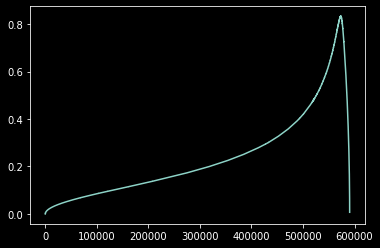

In [163]:
import numba
from sklearn.metrics import matthews_corrcoef, precision_recall_fscore_support

@numba.jit
def mcc(tp, tn, fp, fn):
    sup = tp * tn - fp * fn
    inf = (tp + fp) * (tp + fn) * (tn + fp) * (tn + fn)
    if inf==0:
        return 0
    else:
        return sup / np.sqrt(inf)

#@numba.jit
def eval_mcc(y_true, y_prob, show=False):
    """
    A fast implementation of Anokas mcc optimization code.

    This code takes as input probabilities, and selects the threshold that 
    yields the best MCC score. It is efficient enough to be used as a 
    custom evaluation function in xgboost
    
    Source: https://www.kaggle.com/cpmpml/optimizing-probabilities-for-best-mcc
    Source: https://www.kaggle.com/c/bosch-production-line-performance/forums/t/22917/optimising-probabilities-binary-prediction-script
    Creator: CPMP
    """
    idx = np.argsort(y_prob)
    y_true_sort = y_true[idx]
    n = y_true.shape[0]
    nump = 1.0 * np.sum(y_true) # number of positive
    numn = n - nump # number of negative
    tp = nump
    tn = 0.0
    fp = numn
    fn = 0.0
    best_mcc = 0.0
    best_id = -1
    prev_proba = -1
    best_proba = -1
    mccs = np.zeros(n)
    for i in range(n):
        # all items with idx < i are predicted negative while others are predicted positive
        # only evaluate mcc when probability changes
        proba = y_prob[idx[i]]
        if proba != prev_proba:
            prev_proba = proba
            new_mcc = mcc(tp, tn, fp, fn)
            if new_mcc >= best_mcc:
                best_mcc = new_mcc
                best_id = i
                best_proba = proba
        mccs[i] = new_mcc
        if y_true_sort[i] == 1:
            tp -= 1.0
            fn += 1.0
        else:
            fp -= 1.0
            tn += 1.0
    if show:
        y_pred = (y_prob >= best_proba).astype(int)
        score = matthews_corrcoef(y_true, y_pred)
        plt.plot(mccs)
        return best_proba, best_mcc, y_pred
    else:
        return best_proba,  best_mcc, None

bp, bmcc, yp = eval_mcc(
    y_true = train_df[target].values,
    y_prob = oof,
    show=True
)

In [164]:
bp, bmcc

(0.20989032044283562, 0.8335951833367987)

In [165]:
# Improvement Area: Pred==0, Actual==1
pred = oof>bp
examine = traintr[pred==False]
examine = examine[examine.isFraud==1]
examine.shape

(4782, 394)

In [166]:
badguy = examine.mean()
badguy[['TransactionAmt', 'C1', 'C2', 'D1', 'D2', 'V100', 'V310']]
badguy = {
    'TransactionAmt':    175.132982,
    'C1':                 26.855532,
    'C2':                 31.275574,
    'D1':                 30.312290,
    'D2':                 91.129977,
    'V100':                0.107696,
    'V310':               36.764886,
}
# pick a few columns:


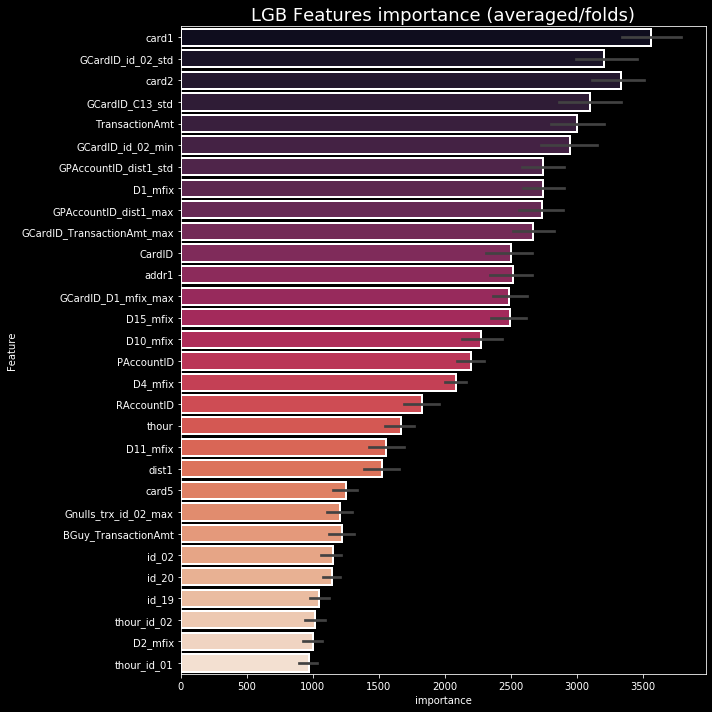

In [167]:
import seaborn as sns
plt.style.use('dark_background')
cols = (feature_importance_df[["Feature", "importance"]]
    .groupby("Feature")
    .mean()
    .sort_values(by="importance", ascending=False)[:30].index)
best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

plt.figure(figsize=(10,10))
sns.barplot(x="importance", y="Feature", data=best_features.sort_values(by="importance",ascending=False),
        edgecolor=('white'), linewidth=2, palette="rocket")
plt.title('LGB Features importance (averaged/folds)', fontsize=18)
plt.tight_layout()

In [113]:
sample_submission = pd.read_csv('./input/sample_submission.csv.zip')
sample_submission['isFraud'] = predictions
sample_submission.to_csv('sub.csv', index=False)
!zip -r -X sub.zip sub.csv

  adding: sub.csv (deflated 60%)


In [15]:
sample_submission.head()

,TransactionID,isFraud
0,3663549,0.000184
1,3663550,0.000195
2,3663551,0.001633
3,3663552,0.000328
4,3663553,0.000302


In [169]:
look = feature_importance_df.groupby('Feature').importance.mean().sort_values(ascending=False)
look[50:100]

Feature
P_emaildomain    606.6
D4               599.8
D11_mfix_mod7    588.4
D10              587.4
D13_mfix         585.6
C1               569.0
id_06            561.4
D6_mfix          468.4
C14              454.0
id_13            451.6
C2               447.6
C6               438.0
D11              431.8
C11              410.0
D12_mfix         397.2
tmonth           396.4
D2               394.2
id_30            368.2
D1               362.2
D2_mfix_mod7     349.4
R_emaildomain    337.0
D5               331.2
C9               325.8
nulls_idn        321.4
D3               320.6
V313             316.8
M5               316.4
D14_mfix_mod7    308.0
id_01            295.4
D8_mfix_mod7     291.8
id_33            288.4
card4            284.6
V307             269.2
M4               260.0
M6               249.6
D5_mfix_mod7     233.0
card3            218.4
id_18            211.2
C5               209.8
V315             199.6
V310             199.2
id_14            198.8
D3_mfix_mod7     198.0
D13

# Better time split

In [170]:
seed = 123

params = {
    'bagging_fraction': 0.80,
    'feature_fraction': 0.3,
    'max_depth': 50,
    'min_child_weight': 0.00298,
    'min_data_in_leaf': 20,
    'num_leaves': 382,
    'reg_alpha': 1,
    'reg_lambda': 2,

#     'min_data_in_leaf': int(LGB_BO.max['params']['min_data_in_leaf']), 
#     'num_leaves': int(LGB_BO.max['params']['num_leaves']), 
#     #'learning_rate': LGB_BO.max['params']['learning_rate'],
#     'min_child_weight': LGB_BO.max['params']['min_child_weight'],
#     'bagging_fraction': LGB_BO.max['params']['bagging_fraction'], 
#     'feature_fraction': LGB_BO.max['params']['feature_fraction'],
#     'reg_lambda': LGB_BO.max['params']['reg_lambda'],
#     'reg_alpha': LGB_BO.max['params']['reg_alpha'],
#     'max_depth': int(LGB_BO.max['params']['max_depth']), 
    
    'objective': 'binary',
    'save_binary': True,
    'seed': seed,
    'feature_fraction_seed': seed,
    'bagging_seed': seed,
    'drop_seed': seed,
    'data_random_seed': seed,
    'boosting_type': 'gbdt',
    'verbose': 1,
    'boost_from_average': True,
    'metric':'auc',
    
    'is_unbalance': False,
    #'scale_pos_weight':2,
}

In [104]:
# Who are these guys?
# Can we transform them into a single meta-feature and avoid overfitting somehow:
# train_features = [f for f in train_features if f not in ['V188', 'V189', 'V200', 'V201', 'V244', 'V246', 'V257', 'V258']]
train_features = [f for f in train_features if f not in [
    'C7',
    'V45',
    'V186', 'V187', 'V188', 'V189', 'V190',
    'V199', 'V200', 'V201',
    'V242', 'V243', 'V244', 'V245', 'V246',
    'V257', 'V258', 'V259',
]]

In [131]:
# Who are these guys?
# Can we transform them into a single meta-feature and avoid overfitting somehow:
# train_features = [f for f in train_features if f not in ['V188', 'V189', 'V200', 'V201', 'V244', 'V246', 'V257', 'V258']]
likely_larbage = [
    'OHE_R_emaildomain',
    'V305',
    'OHE_P_emaildomain',
    'id_27',
    'V65',
    'V68',
    'V120',
    'V241',
    'V240',
    'V107',
    'V122',
    'V117',
    'V118',
    'V121'
]

# train_features = [f for f in train_features if f not in [
# #     'C7', 'C11', 'C12', #2
#     'C4',
#     'V44', 'V45',
#     'V186', 'V187', 'V188', 'V189', 'V190',
#     'V199', 'V200', 'V201',
#     'V242', 'V243', 'V244', 'V245', 'V246',
#     'V257', 'V258', 'V259',
# ]]#  and f not in likely_larbage]

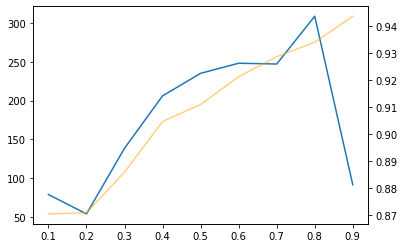

,n_splits,rowauc
train_frac,,
0.1,79.0,0.870550
0.2,54.0,0.870961
0.3,138.5,0.885965
0.4,206.0,0.904659
0.5,235.0,0.910928
0.6,248.0,0.921175
0.7,247.0,0.928558
0.8,308.5,0.933917
0.9,91.5,0.943497


In [179]:
opt = pd.DataFrame({
    'train_frac': [0.1, 0.1, 0.2, 0.2, 0.3, 0.3, 0.4, 0.4, 0.5, 0.5, 0.6, 0.6, 0.7, 0.7, 0.8, 0.8, 0.9, 0.9],
    'n_splits': [73, 85, 47, 61, 129, 148, 210, 202, 238, 232, 245, 251, 253, 241, 308, 309, 100, 83],
    'rowauc': [0.8690, 0.8721, 0.873646, 0.868276, 0.886307, 0.885623, 0.905196, 0.904122, 0.910311, 0.911545, 0.920712, 0.921639, 0.92853, 0.928586, 0.933343, 0.934491, 0.943982, 0.943013],
})
opt = opt.groupby('train_frac').mean()

plt.plot(opt.n_splits)
ax = plt.twinx()
ax.plot(opt.rowauc, c='orange', alpha=0.5)
plt.show()

opt

Training on fold 1
TRAIN: 531486 TEST: 59054
[     0      1      2 ... 531483 531484 531485] [531486 531487 531488 ... 590537 590538 590539]
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[83]	training's auc: 0.996596	valid_1's auc: 0.943013
Fold 1 finished in 0:01:21.248712

------------------------------
Training has finished.
Total training time is 0:01:21.249191

	CV roc score        : 0.9430, std: 0.0000. 
	CV accuracy score   : 0.9740, std: 0.0000. 
	CV recall score     : 0.3656, std: 0.0000. 
	CV precision score  : 0.8579, std: 0.0000. 
	CV f1 score         : 0.5127, std: 0.0000.
------------------------------


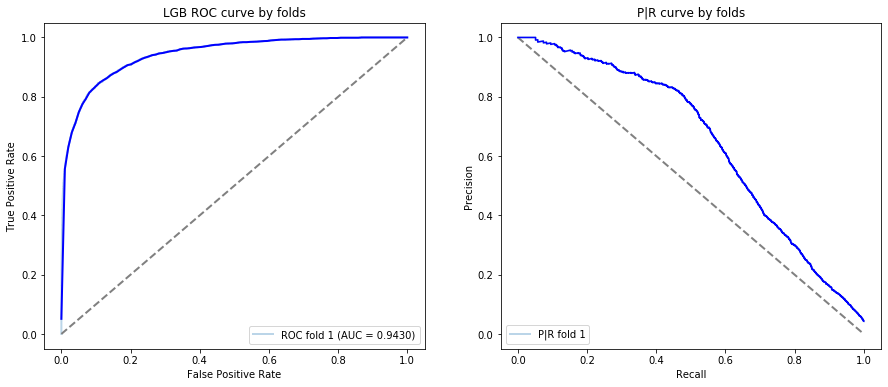

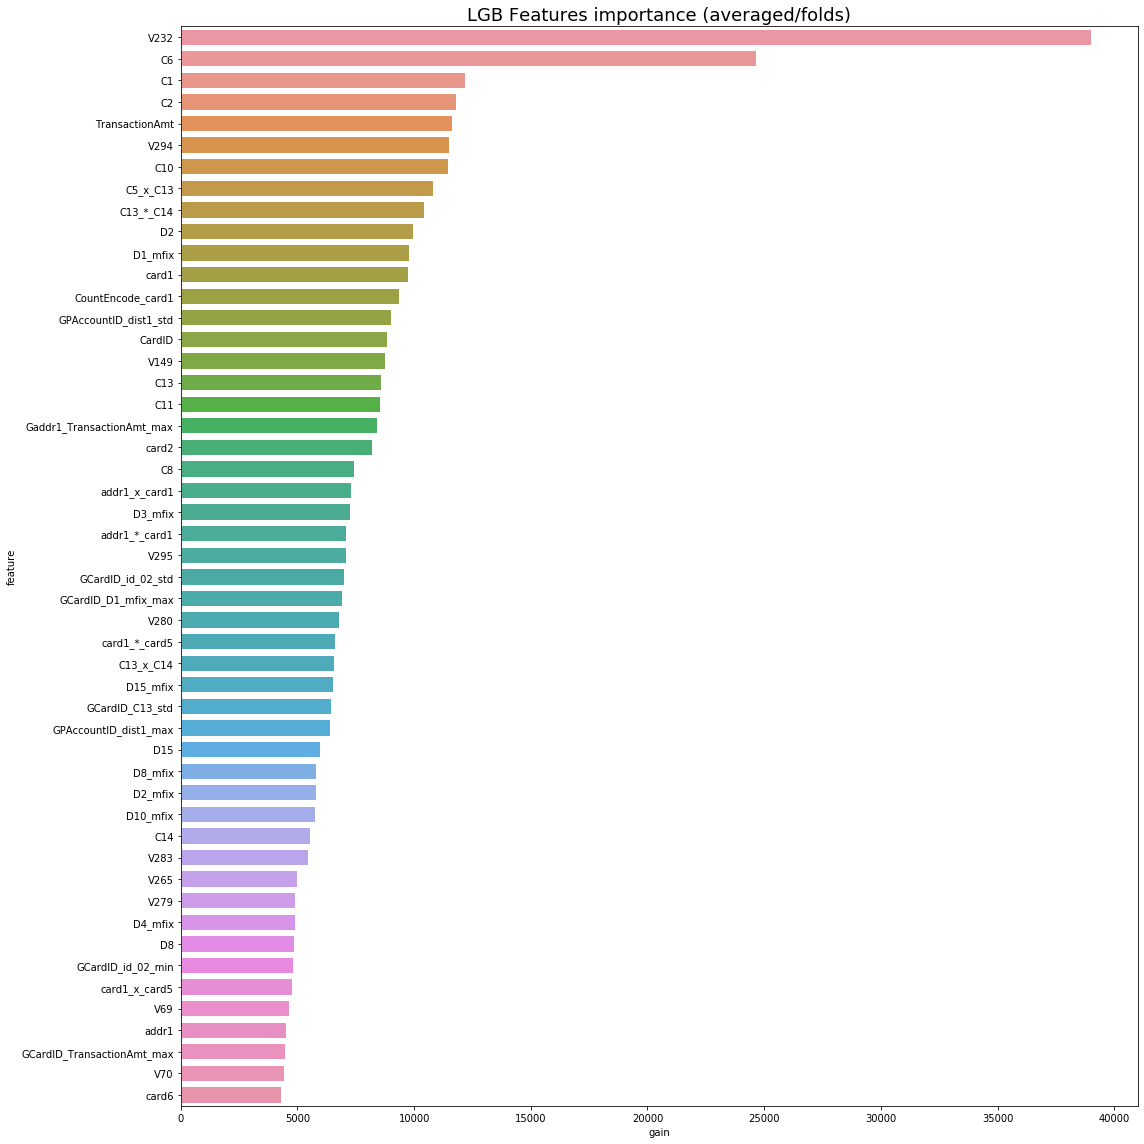

In [169]:
# Feature Selection Validator
recalls    = []
roc_aucs   = []
f1_scores  = []
accuracies = []
precisions = []
all_y_true = []
all_y_pred = []
tprs = []

FPs = []
FNs = []
y_indices = []

# preds = np.zeros(len(test))
oof = np.zeros(trx_size) # todo: logic for last fold
mean_fpr = np.linspace(0,1,100)
fi = pd.DataFrame()
fi['feature'] = train_features

one5 = data_trn.shape[0]//3
tscv = TimeSeriesSplit(train_size=one5, test_size=one5, force_step_size=one5//2, n_splits=5)

f, axs = plt.subplots(1,2,figsize=(15,6))
axs[0].set_title('LGB ROC curve by folds')
axs[0].set_xlabel('False Positive Rate')
axs[0].set_ylabel('True Positive Rate')
axs[1].set_title('P|R curve by folds')
axs[1].set_xlabel('Recall')
axs[1].set_ylabel('Precision')

HOLDA = [
#     [np.arange(trx_size//2), np.arange(trx_size//2,trx_size)], #238
    [np.arange(9*trx_size//10), np.arange(9*trx_size//10,trx_size)], #238
]

training_start_time = time()
# for fold, (index_trn, index_val) in enumerate(tscv.split(data_trn)):
for fold, (index_trn, index_val) in enumerate(HOLDA):
    start_time = time()
    print('Training on fold {}'.format(fold + 1))
    print('TRAIN:', len(index_trn), 'TEST:', len(index_val))
    print(index_trn, index_val)
    
    trn_data = lgb.Dataset(data_trn[train_features].iloc[index_trn], label=data_trn.isFraud.iloc[index_trn])
    val_data = lgb.Dataset(data_trn[train_features].iloc[index_val], label=data_trn.isFraud.iloc[index_val])
    
    clf = lgb.train(
        params,
        trn_data,
        10000,
        valid_sets = [trn_data, val_data],
        verbose_eval=600,
        early_stopping_rounds=200
    )
    
    
    #preds += clf.predict(test)
    pred = clf.predict(data_trn[train_features].iloc[index_val])
    oof[index_val] = pred
    y_indices.append(index_val)

    # Scores
    # TODO: Calc best threshold???
    y_true = data_trn.iloc[index_val].isFraud.values
    y_pred = oof[index_val]
    all_y_true.append(y_true)
    all_y_pred.append(y_pred)
    
    accuracies.append(accuracy_score(y_true, y_pred.round()))
    recalls.append(recall_score(y_true, y_pred.round()))
    precisions.append(precision_score(y_true, y_pred.round()))
    f1_scores.append(f1_score(y_true, y_pred.round()))
    roc_aucs.append(clf.best_score['valid_1']['auc'])
    
    # Roc, Precion, and Recall curves by fold:
    fpr, tpr, _ = roc_curve(y_true, y_pred) # I believe also returns thresh
    tprs.append(interp(mean_fpr, fpr, tpr))
    axs[0].plot(fpr, tpr, lw=2, alpha=0.3, label='ROC fold %d (AUC = %0.4f)' % (fold+1, roc_aucs[-1]))
    precision, recall, _ = precision_recall_curve(y_true, y_pred)
    axs[1].plot(recall, precision, lw=2, alpha=0.3, label='P|R fold %d' % (fold+1))  
    
    fi['gain_fold_{}'.format(fold + 1)] = clf.feature_importance(importance_type='gain')
    fi['split_fold_{}'.format(fold + 1)] = clf.feature_importance(importance_type='split')
    print('Fold {} finished in {}'.format(fold + 1, str(datetime.timedelta(seconds=time() - start_time))), end='\n\n')
    
    
print('-' * 30)
print('Training has finished.')
print('Total training time is {}'.format(str(datetime.timedelta(seconds=time() - training_start_time))))
print(
    '\n\tCV roc score        : {0:.4f}, std: {1:.4f}.'.format(np.mean(roc_aucs), np.std(roc_aucs)),
    '\n\tCV accuracy score   : {0:.4f}, std: {1:.4f}.'.format(np.mean(accuracies), np.std(accuracies)),
    '\n\tCV recall score     : {0:.4f}, std: {1:.4f}.'.format(np.mean(recalls), np.std(recalls)),
    '\n\tCV precision score  : {0:.4f}, std: {1:.4f}.'.format(np.mean(precisions), np.std(precisions)),
    '\n\tCV f1 score         : {0:.4f}, std: {1:.4f}.'.format(np.mean(f1_scores), np.std(f1_scores))
)
print('-' * 30)


#ROC 
axs[0].legend(loc="lower right")
axs[0].plot([0,1],[0,1],linestyle = '--',lw = 2,color = 'grey')
mean_tpr = np.mean(tprs, axis=0)
mean_auc = auc(mean_fpr, mean_tpr)
axs[0].plot(mean_fpr, mean_tpr, color='blue', label=r'Mean ROC (AUC = %0.4f)' % (np.mean(roc_aucs)),lw=2, alpha=1)

# PR plt
axs[1].legend(loc="lower left")
axs[1].plot([0,1],[1,0],linestyle = '--',lw = 2,color = 'grey')
all_y_true = np.concatenate(all_y_true)
all_y_pred = np.concatenate(all_y_pred)
precision, recall, _ = precision_recall_curve(all_y_true, all_y_pred)
axs[1].plot(recall, precision, color='blue', label=r'Mean P|R')
plt.show()


# FIs:
fi['gain'] = fi[[f for f in fi if 'gain_fold_' in f]].mean(axis=1)
fi['split'] = fi[[f for f in fi if 'split_fold_' in f]].mean(axis=1)
fi.to_csv('feature_importances.csv')
cols = fi.sort_values(by="gain", ascending=False).feature[:50]
best_features = fi.loc[fi.feature.isin(cols)].sort_values(by='gain', ascending=False)

plt.figure(figsize=(16, 16))
sns.barplot(x="gain", y="feature", data=best_features, edgecolor=('white'), linewidth=2)#, palette="rocket")
plt.title('LGB Features importance (averaged/folds)', fontsize=18)
plt.tight_layout()

In [129]:
fi['gps'] = fi.gain / fi.split
z = fi[['feature','gain','split','gps']].sort_values(by='gps', ascending=False).reset_index(drop=True)
z

,feature,gain,split,gps
43,V328,61.602018,6.0,10.267003
44,id_12,61.106342,6.0,10.184390
45,id_28,9.903830,1.0,9.903830
87,V288,51.600363,9.0,5.733374
94,V114,21.315421,4.0,5.328855
117,V153,25.089777,6.0,4.181630
118,id_22,4.180970,1.0,4.180970
120,V138,20.740410,5.0,4.148082
129,V118,7.655730,2.0,3.827865
153,D9,3.380520,1.0,3.380520


In [108]:
z = fi.sort_values(by='gain', ascending=False).reset_index(drop=True)
z

,feature,gain_fold_1,split_fold_1,gain,split,gps
0,V274,14947.679917,140,14947.679917,140.0,106.769142
1,D1_mfix,10300.084035,2373,10300.084035,2373.0,4.340533
2,V308,9306.842949,303,9306.842949,303.0,30.715653
3,C1,9176.194400,368,9176.194400,368.0,24.935311
4,C13_*_C14,8779.902745,705,8779.902745,705.0,12.453763
5,V317,8764.783385,251,8764.783385,251.0,34.919456
6,V153,7507.450094,35,7507.450094,35.0,214.498574
7,card2,7164.034713,1622,7164.034713,1622.0,4.416791
8,PAccountID,6578.125462,1511,6578.125462,1511.0,4.353491
9,Gaddr1_TransactionAmt_mean,6195.117728,1435,6195.117728,1435.0,4.317155


In [109]:
# TODO: Get rid of some of these
z[z.feature.str.contains('_x_|_\*_')]

,feature,gain_fold_1,split_fold_1,gain,split,gps
4,C13_*_C14,8779.902745,705,8779.902745,705.0,12.453763
12,C13_x_C14,5425.915502,787,5425.915502,787.0,6.894429
19,addr1_*_card1,4655.386529,2138,4655.386529,2138.0,2.177449
21,addr1_x_card1,4453.710013,2398,4453.710013,2398.0,1.857260
23,card1_*_card5,4172.520805,2083,4172.520805,2083.0,2.003130
39,card1_x_card5,2705.792469,1776,2705.792469,1776.0,1.523532
75,C5_x_C14,1493.392201,588,1493.392201,588.0,2.539783
81,C5_x_C13,1430.070718,557,1430.070718,557.0,2.567452
97,C5_*_C14,1251.079087,203,1251.079087,203.0,6.162951
110,C5_x_C9,1019.486201,422,1019.486201,422.0,2.415844


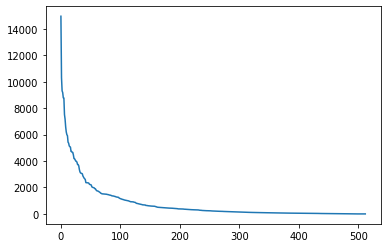

                       feature          gain
0                         V274  14947.679917
1                      D1_mfix  10300.084035
2                         V308   9306.842949
3                           C1   9176.194400
4                    C13_*_C14   8779.902745
5                         V317   8764.783385
6                         V153   7507.450094
7                        card2   7164.034713
8                   PAccountID   6578.125462
9   Gaddr1_TransactionAmt_mean   6195.117728
10                        V264   5992.130490
11   Gaddr1_TransactionAmt_max   5915.572545
12                   C13_x_C14   5425.915502
13                        V265   5350.412202
14                    D10_mfix   5140.582374
15           CountEncode_card1   5088.072429
16                          D2   5051.719357
17              TransactionAmt   4725.919597
18             GCardID_C13_std   4720.381733
19               addr1_*_card1   4655.386529
20           GCardID_id_02_std   4648.467621
21        

In [110]:
plt.plot(z.gain.values)
plt.show()
for i in range(0,600,50):
    print(z[i:i+50][['feature','gain']], end='\n\n')

# SUBMISSION

In [201]:
# Feature Selection Validator

preds = []

training_start_time = time()
# for fold, (index_trn, index_val) in enumerate(tscv.split(data_trn)):
for run in range(3):
    start_time = time()
    print('Training on run {}'.format(run + 1))

    trn_data = lgb.Dataset(data_trn[train_features], label=data_trn.isFraud)
    
    params['seed']= seed+run
    params['feature_fraction_seed']= seed+run
    params['bagging_seed']= seed+run
    params['drop_seed']= seed+run
    params['data_random_seed']= seed+run
    
    clf = lgb.train(
        params,
        trn_data,
        valid_sets = [trn_data],
        num_boost_round=265,
        early_stopping_rounds=2000
    )
    
    preds.append( clf.predict(data_sub[train_features]) )
    print('Fold {} finished in {}'.format(fold + 1, str(datetime.timedelta(seconds=time() - start_time))), end='\n\n')
    

Training on run 1
[1]	training's auc: 0.870465
Training until validation scores don't improve for 2000 rounds.
[2]	training's auc: 0.893265
[3]	training's auc: 0.904042
[4]	training's auc: 0.909633
[5]	training's auc: 0.914787
[6]	training's auc: 0.921137
[7]	training's auc: 0.923842
[8]	training's auc: 0.927921
[9]	training's auc: 0.930335
[10]	training's auc: 0.932309
[11]	training's auc: 0.934215
[12]	training's auc: 0.936379
[13]	training's auc: 0.938464
[14]	training's auc: 0.941725
[15]	training's auc: 0.944313
[16]	training's auc: 0.946373
[17]	training's auc: 0.947436
[18]	training's auc: 0.948873
[19]	training's auc: 0.951563
[20]	training's auc: 0.953418
[21]	training's auc: 0.95488
[22]	training's auc: 0.956849
[23]	training's auc: 0.958459
[24]	training's auc: 0.960096
[25]	training's auc: 0.961166
[26]	training's auc: 0.962763
[27]	training's auc: 0.96432
[28]	training's auc: 0.965628
[29]	training's auc: 0.967318
[30]	training's auc: 0.968612
[31]	training's auc: 0.969972

Fold 1 finished in 0:01:39.376718

Training on run 2
[1]	training's auc: 0.871999
Training until validation scores don't improve for 2000 rounds.
[2]	training's auc: 0.889154
[3]	training's auc: 0.898419
[4]	training's auc: 0.910509
[5]	training's auc: 0.91631
[6]	training's auc: 0.919543
[7]	training's auc: 0.921758
[8]	training's auc: 0.925314
[9]	training's auc: 0.927295
[10]	training's auc: 0.930189
[11]	training's auc: 0.933274
[12]	training's auc: 0.935139
[13]	training's auc: 0.938054
[14]	training's auc: 0.940727
[15]	training's auc: 0.942175
[16]	training's auc: 0.945036
[17]	training's auc: 0.948106
[18]	training's auc: 0.950143
[19]	training's auc: 0.951895
[20]	training's auc: 0.953695
[21]	training's auc: 0.955272
[22]	training's auc: 0.956507
[23]	training's auc: 0.957817
[24]	training's auc: 0.959232
[25]	training's auc: 0.960603
[26]	training's auc: 0.961787
[27]	training's auc: 0.963358
[28]	training's auc: 0.965293
[29]	training's auc: 0.96684
[30]	training's auc: 0.9

Fold 1 finished in 0:01:39.412502

Training on run 3
[1]	training's auc: 0.879353
Training until validation scores don't improve for 2000 rounds.
[2]	training's auc: 0.897191
[3]	training's auc: 0.904575
[4]	training's auc: 0.909763
[5]	training's auc: 0.914096
[6]	training's auc: 0.918932
[7]	training's auc: 0.923382
[8]	training's auc: 0.926593
[9]	training's auc: 0.929332
[10]	training's auc: 0.931946
[11]	training's auc: 0.933999
[12]	training's auc: 0.936135
[13]	training's auc: 0.938034
[14]	training's auc: 0.939584
[15]	training's auc: 0.941069
[16]	training's auc: 0.943389
[17]	training's auc: 0.946767
[18]	training's auc: 0.949467
[19]	training's auc: 0.951312
[20]	training's auc: 0.953117
[21]	training's auc: 0.954518
[22]	training's auc: 0.95615
[23]	training's auc: 0.95805
[24]	training's auc: 0.960661
[25]	training's auc: 0.96204
[26]	training's auc: 0.963997
[27]	training's auc: 0.965281
[28]	training's auc: 0.967131
[29]	training's auc: 0.968403
[30]	training's auc: 0.96

Fold 1 finished in 0:01:38.012079



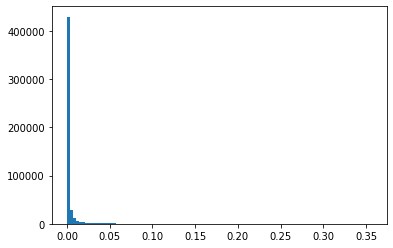

updating: sub.csv (deflated 60%)


In [202]:
import numpy as np
p = np.array(preds)
plt.hist(p.std(axis=0), 100)
plt.show()

sample_submission = pd.read_csv('./input/sample_submission.csv.zip')
sample_submission['isFraud'] = p.mean(axis=0)
sample_submission.to_csv('sub.csv', index=False)
!zip -r -X sub.zip sub.csv

# More EDA

In [ ]:
V160 = grand sum
V165 = half sum?
V332,333,203 = sums


In [407]:
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [386]:
# TransactionAmt
# C10
# V126
# V202
# V208
# V210
# V263
# V306
# V331

#V313 D3
traintr.iloc[21651]

TransactionID                    3008651
isFraud                                0
TransactionDT                     573633
TransactionAmt                        20
ProductCD                              W
card1                              12577
card2                                268
card3                                150
card4                               visa
card5                                166
card6                              debit
addr1                                472
addr2                                 87
dist1                                NaN
dist2                                NaN
P_emaildomain              earthlink.net
R_emaildomain                        NaN
C1                                     3
C2                                     4
C3                                     0
C4                                     0
C5                                     3
C6                                     3
C7                                     0
C8              

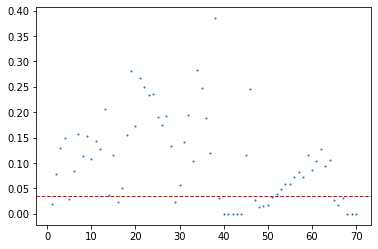

In [335]:
peak = traintr[new_features+['isFraud']].groupby('dollar_weirdness').isFraud.agg(['size','mean']).reset_index().sort_values('dollar_weirdness', ascending=False)
plt.axhline(y=traintr.isFraud.mean(), linestyle='--', linewidth=1, color='red')
plt.scatter(peak.dollar_weirdness.values, peak['mean'].values, s=1)
plt.show()

In [317]:
# Look at the unique values in each col to see if we can do simple FE
for col in traintr.columns:
    look = traintr[col].value_counts().sort_values(ascending=False)
    print(col)
    print(look.head(15), end='\n\n\n')

TransactionID
3145728    1
3335772    1
3153924    1
3155973    1
3158022    1
3178512    1
3160071    1
3164169    1
3166218    1
3168267    1
3170316    1
3172365    1
3174414    1
3162120    1
3289158    1
Name: TransactionID, dtype: int64


isFraud
0    569877
1     20663
Name: isFraud, dtype: int64


TransactionDT
9474817     8
11576951    5
7236588     5
4397066     5
1962054     4
8218708     4
1544629     4
2073296     4
10342227    4
8218707     4
1971839     4
5334992     4
7337054     4
8020359     4
8468062     4
Name: TransactionDT, dtype: int64


TransactionAmt
59.00     30582
117.00    28933
107.95    23954
57.95     23600
100.00    20362
50.00     17009
49.00     15990
226.00    11704
39.00     11095
29.00     10683
47.95      9655
35.95      8909
150.00     8356
171.00     7682
34.00      7652
Name: TransactionAmt, dtype: int64


ProductCD
W    439670
C     68519
R     37699
H     33024
S     11628
Name: ProductCD, dtype: int64


card1
7919     14932
9500     14162
158

M2
T    285468
F     33972
Name: M2, dtype: int64


M3
T    251731
F     67709
Name: M3, dtype: int64


M4
M0    196405
M2     59865
M1     52826
Name: M4, dtype: int64


M5
F    132491
T    107567
Name: M5, dtype: int64


M6
F    227856
T    193324
Name: M6, dtype: int64


M7
F    211374
T     32901
Name: M7, dtype: int64


M8
F    155251
T     89037
Name: M8, dtype: int64


M9
T    205656
F     38632
Name: M9, dtype: int64


V1
1.0    311236
0.0        17
Name: V1, dtype: int64


V2
1.0    298894
2.0     10926
3.0      1181
4.0       163
5.0        36
6.0        30
0.0        20
7.0         2
8.0         1
Name: V2, dtype: int64


V3
1.0    290583
2.0     17763
3.0      2335
4.0       403
5.0        93
6.0        34
0.0        20
7.0        18
8.0         3
9.0         1
Name: V3, dtype: int64


V4
1.0    246500
0.0     56687
2.0      7385
3.0       564
4.0        88
5.0        26
6.0         3
Name: V4, dtype: int64


V5
1.0    242883
0.0     54276
2.0     12610
3.0      1200
4.0   

V54
1.0    295235
0.0    207068
2.0     10445
3.0       603
4.0        76
5.0        14
6.0         3
Name: V54, dtype: int64


V55
1.0     489239
2.0      18464
3.0       3100
4.0       1233
5.0        530
6.0        300
0.0        180
7.0        144
8.0        124
9.0         59
10.0        24
11.0        22
12.0        11
13.0         7
14.0         4
Name: V55, dtype: int64


V56
1.0     472700
2.0      30886
3.0       5610
4.0       1881
5.0        952
6.0        355
7.0        246
0.0        180
8.0        169
9.0        157
10.0        63
12.0        58
22.0        38
11.0        35
14.0        15
Name: V56, dtype: int64


V57
0.0    449807
1.0     61670
2.0      1731
3.0       203
4.0        27
5.0         4
6.0         2
Name: V57, dtype: int64


V58
0.0     449600
1.0      60662
2.0       2675
3.0        300
4.0        105
7.0         45
5.0         31
6.0         10
10.0         6
9.0          5
8.0          5
Name: V58, dtype: int64


V59
0.0     448636
1.0      61876
2.0  

V140
1.0     46598
0.0     21825
2.0      6650
3.0      2920
4.0      1580
5.0       898
6.0       561
7.0       267
8.0       167
9.0       116
10.0       76
11.0       61
13.0       38
12.0       36
15.0       25
Name: V140, dtype: int64


V141
0.0    79211
1.0     2426
2.0      267
3.0       37
4.0        2
5.0        2
Name: V141, dtype: int64


V142
0.0    79152
1.0     2161
2.0      323
3.0      154
4.0       95
5.0       43
6.0       11
9.0        4
8.0        1
7.0        1
Name: V142, dtype: int64


V143
0.0     63872
1.0      3767
2.0      1884
3.0      1032
4.0       709
28.0      584
13.0      516
30.0      417
24.0      409
5.0       380
26.0      369
25.0      364
23.0      354
31.0      351
27.0      341
Name: V143, dtype: int64


V144
0.0     62439
1.0      5418
2.0      2073
11.0     1089
3.0      1054
4.0       600
15.0      435
5.0       365
40.0      364
39.0      353
22.0      327
41.0      317
23.0      296
44.0      275
31.0      269
Name: V144, dtype: int64


V1

V192
1.0     135994
2.0       2129
3.0        298
40.0       116
38.0       102
4.0         91
34.0        61
33.0        54
41.0        49
37.0        42
5.0         40
6.0         37
8.0         36
39.0        35
25.0        33
Name: V192, dtype: int64


V193
1.0     136424
2.0       1811
3.0        247
4.0         83
14.0        60
7.0         55
5.0         51
29.0        50
12.0        48
26.0        47
15.0        43
10.0        42
13.0        42
16.0        41
6.0         41
Name: V193, dtype: int64


V194
1.0    128509
0.0      9693
2.0      1307
3.0       201
4.0        51
5.0        42
6.0        15
7.0         1
Name: V194, dtype: int64


V195
1.0     128253
0.0       9579
2.0       1535
3.0        248
8.0         66
4.0         60
6.0         31
5.0         22
7.0          8
15.0         5
16.0         4
10.0         2
14.0         2
11.0         1
13.0         1
Name: V195, dtype: int64


V196
1.0     136911
2.0       1415
3.0        335
4.0        212
5.0        118
6.0  

V240
1.0    130330
2.0        88
6.0         5
0.0         3
5.0         2
7.0         2
Name: V240, dtype: int64


V241
1.0    130394
2.0        27
0.0         6
4.0         2
5.0         1
Name: V241, dtype: int64


V242
1.0     122640
2.0       5218
3.0       1164
4.0        480
5.0        281
6.0        195
7.0        150
8.0         89
9.0         60
10.0        34
11.0        25
13.0        18
12.0        16
16.0        15
14.0        13
Name: V242, dtype: int64


V243
1.0     120245
2.0       6719
3.0       1536
4.0        669
5.0        351
6.0        235
7.0        168
8.0        124
9.0         80
10.0        45
11.0        32
12.0        32
17.0        26
13.0        23
14.0        21
Name: V243, dtype: int64


V244
1.0     122583
2.0       5139
3.0       1223
4.0        481
5.0        305
6.0        219
7.0        146
8.0         74
9.0         66
10.0        46
11.0        39
12.0        20
16.0        19
13.0        17
14.0        13
Name: V244, dtype: int64


V245
1.0   

V286
0.0    573290
1.0     16122
2.0       949
3.0       136
4.0        11
7.0         8
6.0         6
5.0         5
8.0         1
Name: V286, dtype: int64


V287
0.0     466863
1.0      83560
2.0      22186
3.0       8784
4.0       4863
9.0       1056
5.0        989
7.0        683
6.0        463
8.0        218
10.0       128
11.0        79
18.0        70
19.0        69
12.0        57
Name: V287, dtype: int64


V288
0.0     489641
1.0      91654
2.0       7133
3.0        761
4.0         33
5.0         29
7.0          7
6.0          5
10.0         4
8.0          3
9.0          1
Name: V288, dtype: int64


V289
0.0     487073
1.0      75947
2.0      18920
3.0       5076
4.0       1736
5.0        288
7.0         82
6.0         73
8.0         51
9.0         21
12.0         2
10.0         1
11.0         1
Name: V289, dtype: int64


V290
1.0     551866
2.0      30249
3.0       4936
4.0       1672
5.0        681
6.0        361
7.0        206
8.0        130
9.0         64
10.0        38
11.0  

V327
0.0     75098
1.0      3630
2.0       945
10.0      692
3.0       423
7.0       419
9.0       331
4.0       264
5.0       199
8.0       154
6.0       143
11.0       20
12.0       16
13.0        6
17.0        3
Name: V327, dtype: int64


V328
0.0     73464
1.0      4947
2.0      1574
11.0     1005
3.0       587
4.0       221
15.0      215
5.0       100
12.0       72
6.0        55
8.0        32
7.0        31
14.0       18
9.0        16
10.0       10
Name: V328, dtype: int64


V329
0.0     72114
1.0      5428
2.0      1796
77.0      871
3.0       725
4.0       297
38.0      172
5.0       157
6.0       105
7.0        60
34.0       59
8.0        57
35.0       55
11.0       42
13.0       38
Name: V329, dtype: int64


V330
0.0     72799
1.0      5199
2.0      1739
3.0       648
35.0      419
4.0       242
39.0      224
32.0      176
42.0      151
43.0      132
5.0       128
28.0       61
29.0       58
6.0        56
11.0       54
Name: V330, dtype: int64


V331
0.0      65970
100.0     21

# EDA Look at each col that has > maxbin unique vals for groupings to extract:

In [421]:
vcs = [[col,traintr[col].nunique()] for col in traintr.columns]
vcs = pd.DataFrame(vcs, columns=['col','counts'])
vcs.sort_values('counts', ascending=False)
examine = vcs[vcs.counts<256].col
examine

1                  isFraud
4                ProductCD
7                    card3
8                    card4
9                    card5
10                   card6
12                   addr2
15           P_emaildomain
16           R_emaildomain
19                      C3
25                      C9
39                      D9
46                      M1
47                      M2
48                      M3
49                      M4
50                      M5
51                      M6
52                      M7
53                      M8
54                      M9
55                      V1
56                      V2
57                      V3
58                      V4
59                      V5
60                      V6
61                      V7
62                      V8
63                      V9
64                     V10
65                     V11
66                     V12
67                     V13
68                     V14
69                     V15
70                     V16
7

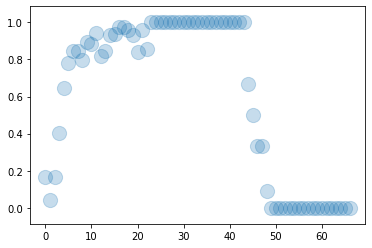

,V258,size,mean
0,33.0,7,1.000000
1,24.0,8,1.000000
2,26.0,6,1.000000
3,27.0,6,1.000000
4,28.0,5,1.000000
5,29.0,6,1.000000
6,30.0,8,1.000000
7,31.0,6,1.000000
8,32.0,6,1.000000
9,34.0,4,1.000000


In [428]:
importantvar = traintr.groupby('V258').isFraud.agg(['size','mean']).sort_values('mean',ascending=False).reset_index()
plt.scatter(importantvar.V258, importantvar['mean'].values, s=importantvar.size, alpha=0.25)
plt.show()
importantvar

In [50]:
def timeplot(data, f):
    _, ax = plt.subplots(1,2,figsize=(12,7))
    z = traintr[['TransactionDT',f,'isFraud']].copy()
    z.replace([np.inf, -np.inf], np.nan, inplace=True)
    z = z[~z[f].isna()]
    ax[0].set_title(f + ' Time Series')
    ax[0].scatter(z[z.isFraud==0].TransactionDT, z[z.isFraud==0][f],s=1,alpha=0.1)
    ax[0].scatter(z[z.isFraud==1].TransactionDT, z[z.isFraud==1][f],s=1,alpha=0.1)
    ax[1].set_title(f + ' Histogram')
    ax[1].hist(
        [
            z[z.isFraud==0][f],
            z[z.isFraud==1][f]
        ],
        100, #z[f].nunique(),
        stacked=True, density=True, orientation='horizontal'
    )
    ax[1].axes.get_yaxis().set_visible(False)
    plt.tight_layout()
    plt.show()

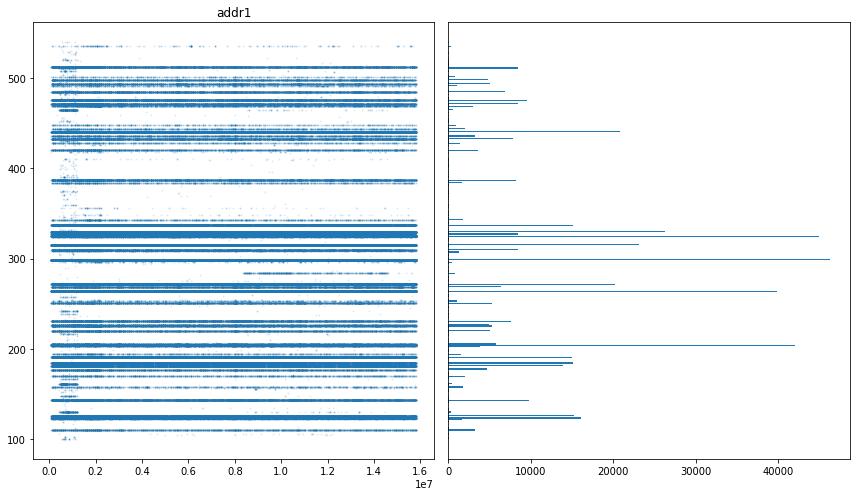

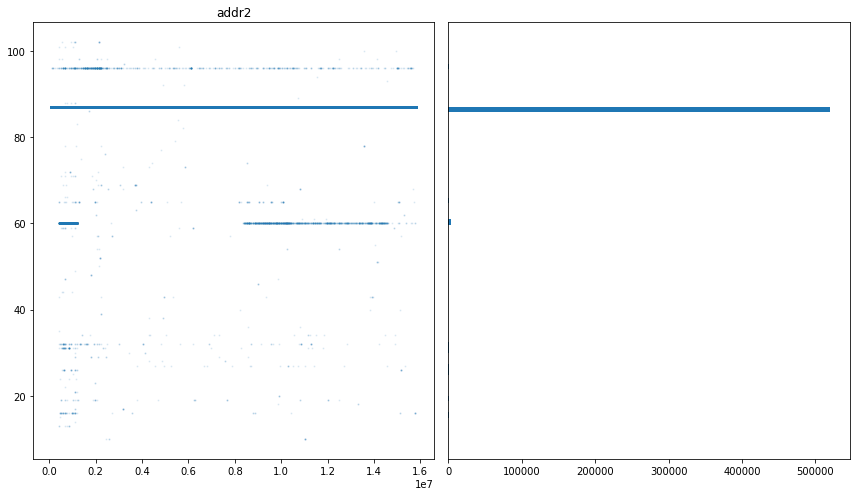

In [797]:
timeplot(traintr, 'addr1')
timeplot(traintr, 'addr2')

# Test for good OHE Features:

In [105]:
# Find values in columns where isFraud/isFraudShape >> !isFraud/~isFraudShape
min_fraud_diff = 0.3
mean_isFraud = traintr.isFraud.mean()

OHE = {}
for col in tqdm(traintr.columns):
    if col in ['isFraud', 'TransactionID']: continue # -_-!

    col_nu = traintr[col].nunique()
    if col_nu < 45: continue # Number val bounds
    if col_nu > 255*2: continue # Number val bounds
        
    frate = traintr.groupby(col).isFraud.agg(['size','mean'])
    frate = frate[frate['size']>50].reset_index().sort_values('mean', ascending=False) # Sample Bounds
    if frate.shape[0] == 0: continue

    OHE[col] = {
        'na_ratio': np.round(100*traintr[col].isna().sum() / traintr.shape[0],3),
        'nunique': col_nu,
    }
    for val, cnt, fmean in frate.values:
        diff = fmean - mean_isFraud
        # We Focus on Target==1 rather than 0 due to data imbalance...
        # if np.abs(diff) < min_fraud_diff: continue
        if diff < min_fraud_diff: continue
        OHE[col][val] = [int(cnt), np.round(diff,5), ]#, np.round(fmean,5)]
        # 'protonmail.com': [76, 0.3729, 0.40789]},
        
    if len(OHE[col]) == 2:
        del OHE[col]
        
OHE

100%|██████████| 394/394 [00:02<00:00, 157.46it/s]


{'card2': {'na_ratio': 1.513,
  'nunique': 500,
  289.0: [118, 0.37179],
  405.0: [228, 0.36852],
  319.0: [100, 0.35501],
  176.0: [513, 0.32563]},
 'addr2': {'na_ratio': 11.126, 'nunique': 74, 65.0: [82, 0.5016]},
 'P_emaildomain': {'na_ratio': 15.995,
  'nunique': 59,
  'protonmail.com': [76, 0.3729]},
 'R_emaildomain': {'na_ratio': 76.752,
  'nunique': 60,
  'mail.com': [122, 0.34206]},
 'V37': {'na_ratio': 28.613,
  'nunique': 55,
  11.0: [60, 0.46501],
  10.0: [104, 0.43616],
  9.0: [168, 0.41739],
  8.0: [193, 0.31216]},
 'V38': {'na_ratio': 28.613,
  'nunique': 55,
  12.0: [108, 0.54834],
  11.0: [105, 0.46025],
  10.0: [144, 0.4164],
  9.0: [164, 0.31257],
  7.0: [426, 0.30773]},
 'V44': {'na_ratio': 28.613,
  'nunique': 49,
  10.0: [52, 0.92655],
  9.0: [102, 0.92579],
  7.0: [138, 0.91429],
  8.0: [83, 0.89272],
  6.0: [208, 0.77751],
  5.0: [319, 0.7299],
  4.0: [615, 0.65119]},
 'V45': {'na_ratio': 28.613,
  'nunique': 49,
  9.0: [143, 0.92305],
  10.0: [77, 0.91306],
  8.

In [86]:
import datetime
START_DATE = '2017-12-01'
startdate = datetime.datetime.strptime(START_DATE, '%Y-%m-%d')
traintr['tdt'] = traintr['TransactionDT'].apply(lambda x: (startdate + datetime.timedelta(seconds = x)))

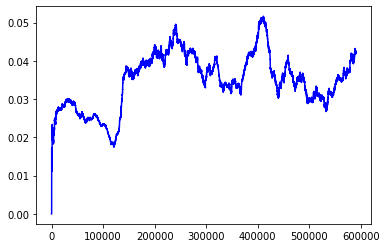

In [98]:
plt.plot(traintr.rolling(on='tdt',window=datetime.timedelta(days = 7)).isFraud.mean(), c='blue')
plt.show()

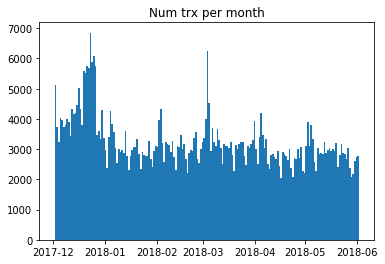

In [103]:
plt.title('Num trx per month')
plt.hist(traintr.tdt,182)
plt.show()

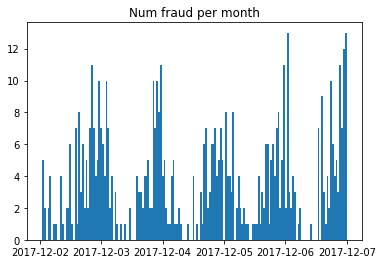

In [113]:
plt.title('Num fraud per month')
z = traintr[traintr.isFraud==1]
z = z[z.tdt<'2017-12-07']
plt.hist(z.tdt,7*24) # days
plt.show()

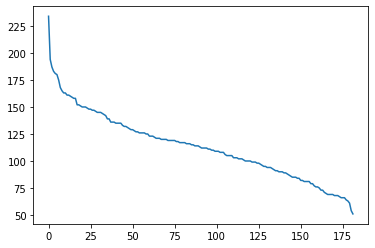

In [107]:
traintr['tdt_d'] = traintr.tdt.dt.date
z = traintr[traintr.isFraud==1].groupby('tdt_d').size().sort_values(ascending=False)
plt.plot(z.values)
plt.show()

In [108]:
z

tdt_d
2018-02-03    234
2018-03-28    194
2018-02-24    187
2018-02-04    183
2018-03-31    181
2018-03-02    180
2018-01-20    175
2018-01-29    168
2018-02-01    165
2018-03-27    163
2018-02-02    163
2018-03-24    161
2017-12-19    161
2018-01-13    160
2018-01-04    159
2017-12-31    158
2018-01-26    158
2018-03-17    152
2018-02-10    152
2018-03-04    151
2018-03-06    150
2017-12-29    150
2018-03-25    150
2018-01-01    149
2018-04-05    148
2018-01-21    148
2018-03-03    147
2017-12-23    147
2018-05-19    146
2018-05-26    145
             ... 
2018-05-22     81
2018-02-22     81
2018-03-05     81
2018-05-08     81
2018-04-27     79
2018-01-23     79
2018-05-14     77
2017-12-25     76
2018-01-25     76
2018-02-27     75
2018-04-16     73
2018-05-15     73
2018-04-23     71
2017-12-17     70
2018-04-08     69
2018-04-17     69
2018-05-07     69
2018-04-30     69
2018-03-12     68
2018-05-21     68
2018-05-11     68
2018-04-25     67
2018-05-29     66
2018-04-29     66
2018

In [90]:
# C1-C14: 
# D1-D15

In [84]:
def timeplot(data, f):
    _, ax = plt.subplots(1,2,figsize=(12,7))
    z = traintr[['TransactionDT',f,'isFraud']].copy()
    z.replace([np.inf, -np.inf], np.nan, inplace=True)
    z = z[~z[f].isna()]
    ax[0].set_title(f + ' Time Series')
    ax[0].scatter(z[z.isFraud==0].TransactionDT, z[z.isFraud==0][f],s=1,alpha=0.1)
    ax[0].scatter(z[z.isFraud==1].TransactionDT, z[z.isFraud==1][f],s=1,alpha=0.1)

    ax[1].set_title(f + ' Histogram')
    ax[1].hist(
        [
            z[z.isFraud==0][f],
            z[z.isFraud==1][f]
        ],
        100, #z[f].nunique(),
        stacked=True, density=True, orientation='horizontal'
    )
    ax[1].axes.get_yaxis().set_visible(False)
    plt.tight_layout()
    plt.show()

In [ ]:
# for c in range(1,15):
#     C = 'C'+str(c)
#     for d in range(1,16):
#         D = 'D'+str(d)
#         traintr['look'] = traintr[C] / (1 + (traintr[D] %7))
#         print(C, '/', D, 'mod7+1',traintr[D].mean(), traintr[C].mean())
#         timeplot(traintr, 'look')
#         print('')


In [59]:
traintr.loc[:,traintr.columns[traintr.columns.str.startswith('D')]].isnull().sum().sort_values()

D1       1269
D10     76022
D15     89113
D4     168922
D3     262878
D11    279287
D2     280797
D5     309841
D8     515614
D9     515614
D6     517353
D12    525823
D14    528353
D13    528588
D7     551623
dtype: int64

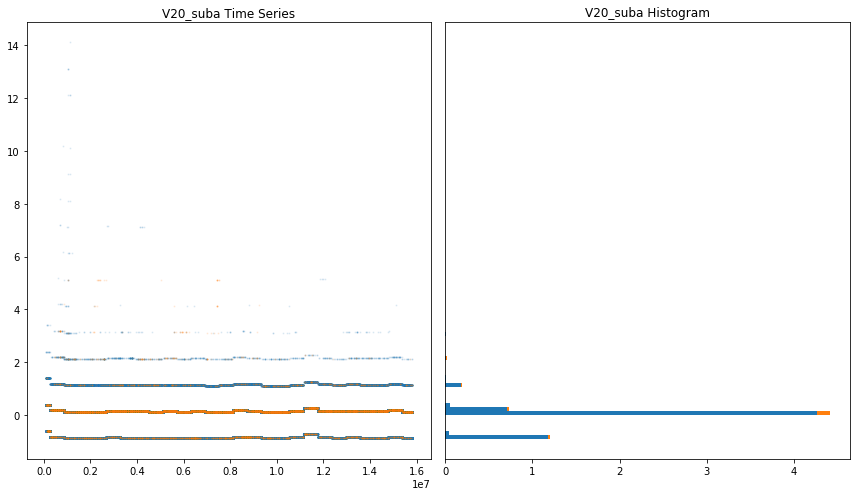

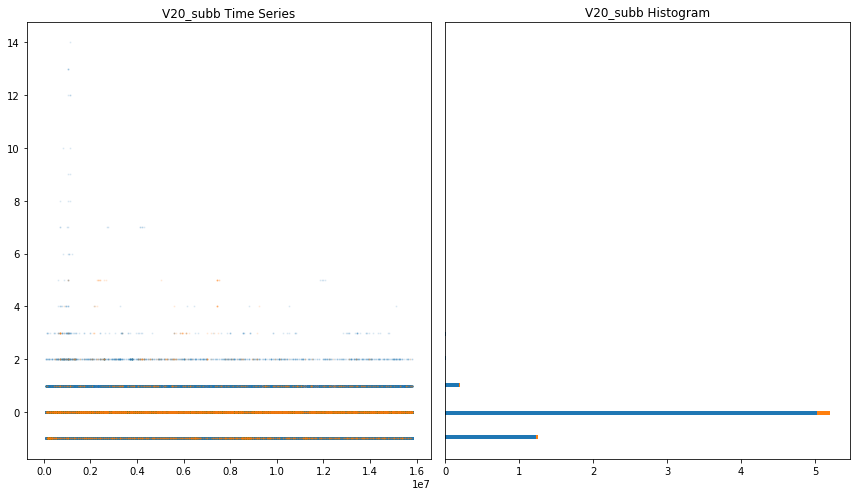

In [78]:
# # calc mean and median D* value per month
# # store difference between ours and the mean or median

# Note: id vars (and D) are the only ones that change f(x)
# So we have to group on other vars instead...


# import datetime
# START_DATE     = '2017-12-01'
# startdate      = datetime.datetime.strptime(START_DATE, '%Y-%m-%d')
# traintr['tdt']    = traintr['TransactionDT'].apply(lambda x: (startdate + datetime.timedelta(seconds = x)))
# traintr['tmonth'] = traintr.tdt.dt.month
# traintr['tweek'] = traintr.tdt.dt.week

var = 'V20'
grp = traintr[[var,'tweek']].groupby('tweek')[var]
mean = grp.mean().reset_index()
median = grp.median().reset_index()
mean.rename(columns={var:var+'_weeklymean'}, inplace=True)
median.rename(columns={var:var+'_weeklymedian'}, inplace=True)

traintr = traintr.merge(mean, how='left', on='tweek')
traintr = traintr.merge(median, how='left', on='tweek')
traintr[var+'_suba'] = traintr[var] - traintr[var+'_weeklymean']
traintr[var+'_subb'] = traintr[var] - traintr[var+'_weeklymedian']

timeplot(traintr, var+'_suba')
timeplot(traintr, var+'_subb')

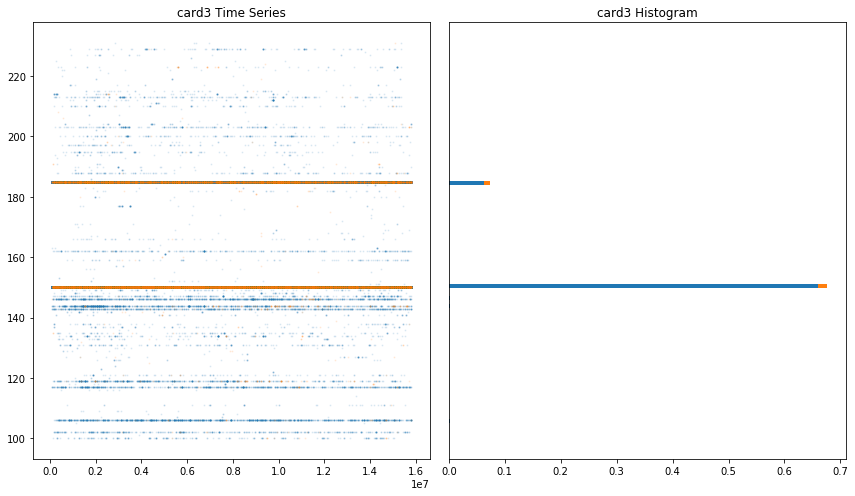

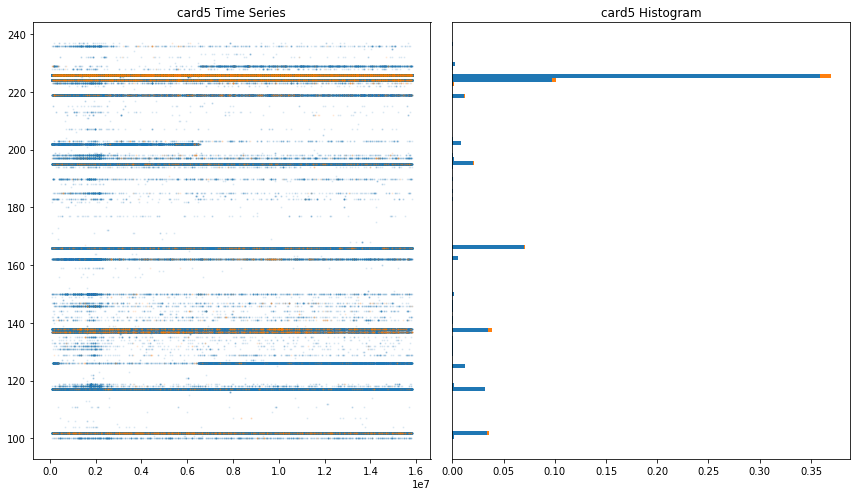

In [85]:
z = traintr[traintr.isFraud==1]
timeplot(z, 'card3')
timeplot(z, 'card5')

In [129]:
traintr = traintr.merge(trainid[['TransactionID','id_01']], how='left', on='TransactionID')

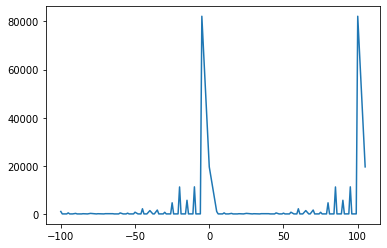

In [123]:
z = trainid.id_01.value_counts().sort_index().reset_index()
a = z.copy()
a['index'] += 105
z = z.append(a, sort=False)
# z = z.iloc[:74]
plt.plot(z['index'], z.id_01)
plt.show()

In [135]:
(24*60*60) / 100

864.0

In [ ]:
id_01 is continuous
thour is continuous
id_01 exhibit bimodal distribution
use cos or sin to encode over its period synced with transaction dt

(within12(thour+thour_off) / % 12) * id_01

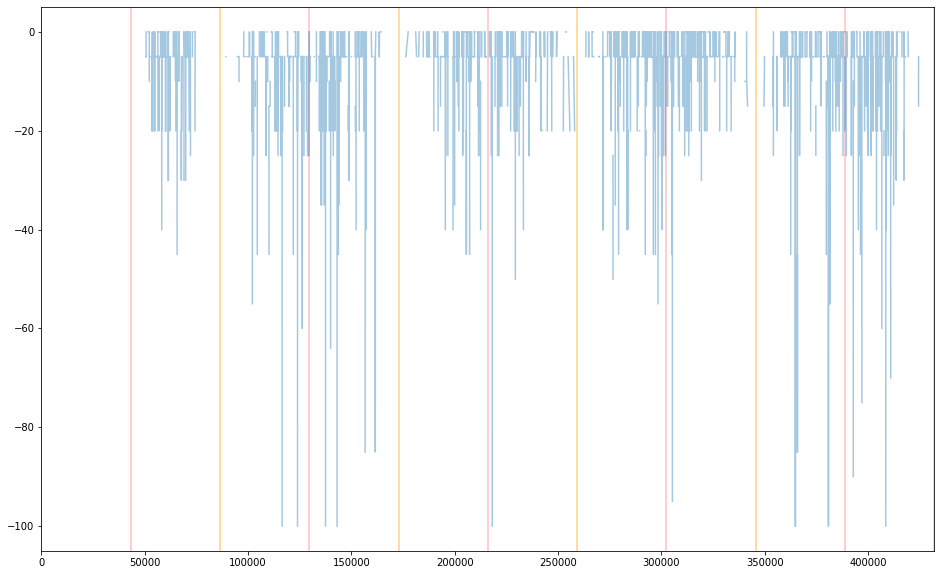

In [238]:
numdays = 5
offhours = 10

traintr['off_tdt'] = traintr.TransactionDT + (24-offhours)*3600
minn = traintr.off_tdt.min() - (traintr.off_tdt.min() % (3600*24))
#print('minn', minn, traintr.off_tdt.min())
traintr.off_tdt -= minn
minn=0

plt.figure(figsize=(16,10))
for i in range(10): plt.axvline(x=3600*24*i, c='orange', alpha=0.5)
for i in range(10): plt.axvline(x=3600*12 + 3600*24*i, c='red', alpha=0.25)
# plt.scatter(traintr.TransactionDT, traintr.id_01, s=.05)
plt.plot(traintr.off_tdt, traintr.id_01, alpha=0.4)
plt.xlim(minn, minn + 3600*24*numdays)
plt.show()


# orange = np.floor(off_tdt / (3600*24)) * (3600*24)
# red = orange + 3600*12

# 'tdt_id_01' = (red-(tdt+3600*offhours)) * id_01
# 'tdt_id_02' = (red-(tdt+3600*offhours)) * id_02

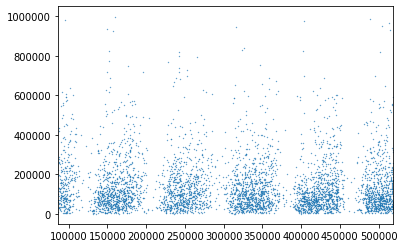

In [150]:
plt.scatter(traintr.TransactionDT, traintr.id_02, s=.1)
plt.xlim(traintr.TransactionDT.min(), traintr.TransactionDT.min() + 3600*24*5)
plt.show()

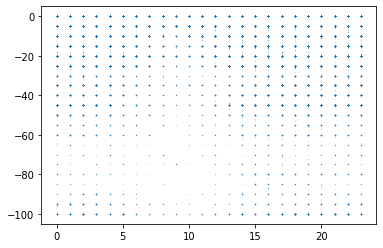

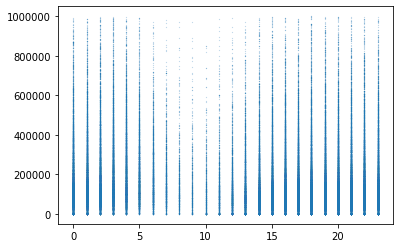

In [261]:
plt.scatter(traintr.thour, traintr.id_01, s=.01)
plt.show()

plt.scatter(traintr.thour, traintr.id_02, s=.01)
plt.show()

In [ ]:
del traintr['thour_id_01_sum']

In [269]:
traintr['thour'] = np.floor(traintr.TransactionDT / 3600) % 24
# look = traintr.groupby('thour').id_01
# plt.plot(look.mean())
# ax = plt.twinx()
# ax.plot(look.sum(), c='orange')
# plt.show()

look = traintr.groupby('thour').id_01.mean().reset_index()
look.rename(columns={'id_01':'thour_id_01_mean'}, inplace=True)
traintr = traintr.merge(look, how='left', on='thour')
traintr['thour_id_01_mean_diff'] = traintr.id_01 - traintr.thour_id_01_mean # or std or error or ...
# @ 9h, id_01 is the least
# @18h, id_02 is the least

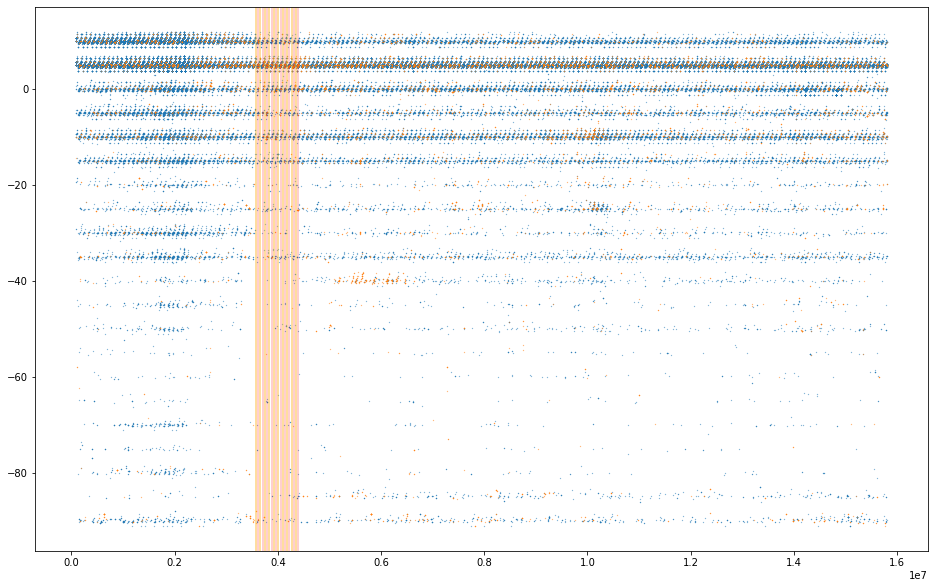

In [271]:
offhours = 10

minn = traintr.TransactionDT.min() + 3600*24*40
numdays = 5
offhours = 10
plt.figure(figsize=(16,10))
for i in range(10): plt.axvline(x=minn + 3600*offhours      + 3600*24*i, c='orange', alpha=0.5)
for i in range(10): plt.axvline(x=minn + 3600*(offhours+12) + 3600*24*i, c='red', alpha=0.25)
plt.scatter(traintr[traintr.isFraud==0].TransactionDT, traintr[traintr.isFraud==0].thour_id_01_mean_diff, s=.05)
plt.scatter(traintr[traintr.isFraud==1].TransactionDT, traintr[traintr.isFraud==1].thour_id_01_mean_diff, s=.05)

# plt.plot(traintr.TransactionDT, traintr.id_01, alpha=0.4)
# plt.xlim(minn, minn + 3600*24*numdays)
plt.show()

# Modeling Time

In [302]:
traintr[z==True].card3.value_counts()

Series([], Name: card3, dtype: int64)

# SNS EDA

In [6]:
# Sample 500 fraud and 500 non-fraud examples to plot
sampled_train = pd.concat([
    traintr.loc[traintr['isFraud'] == 0].sample(5000),
    traintr.loc[traintr['isFraud'] == 1].sample(5000)
])

In [15]:
c_cols = ['C'+str(i) for i in range(1,15)]


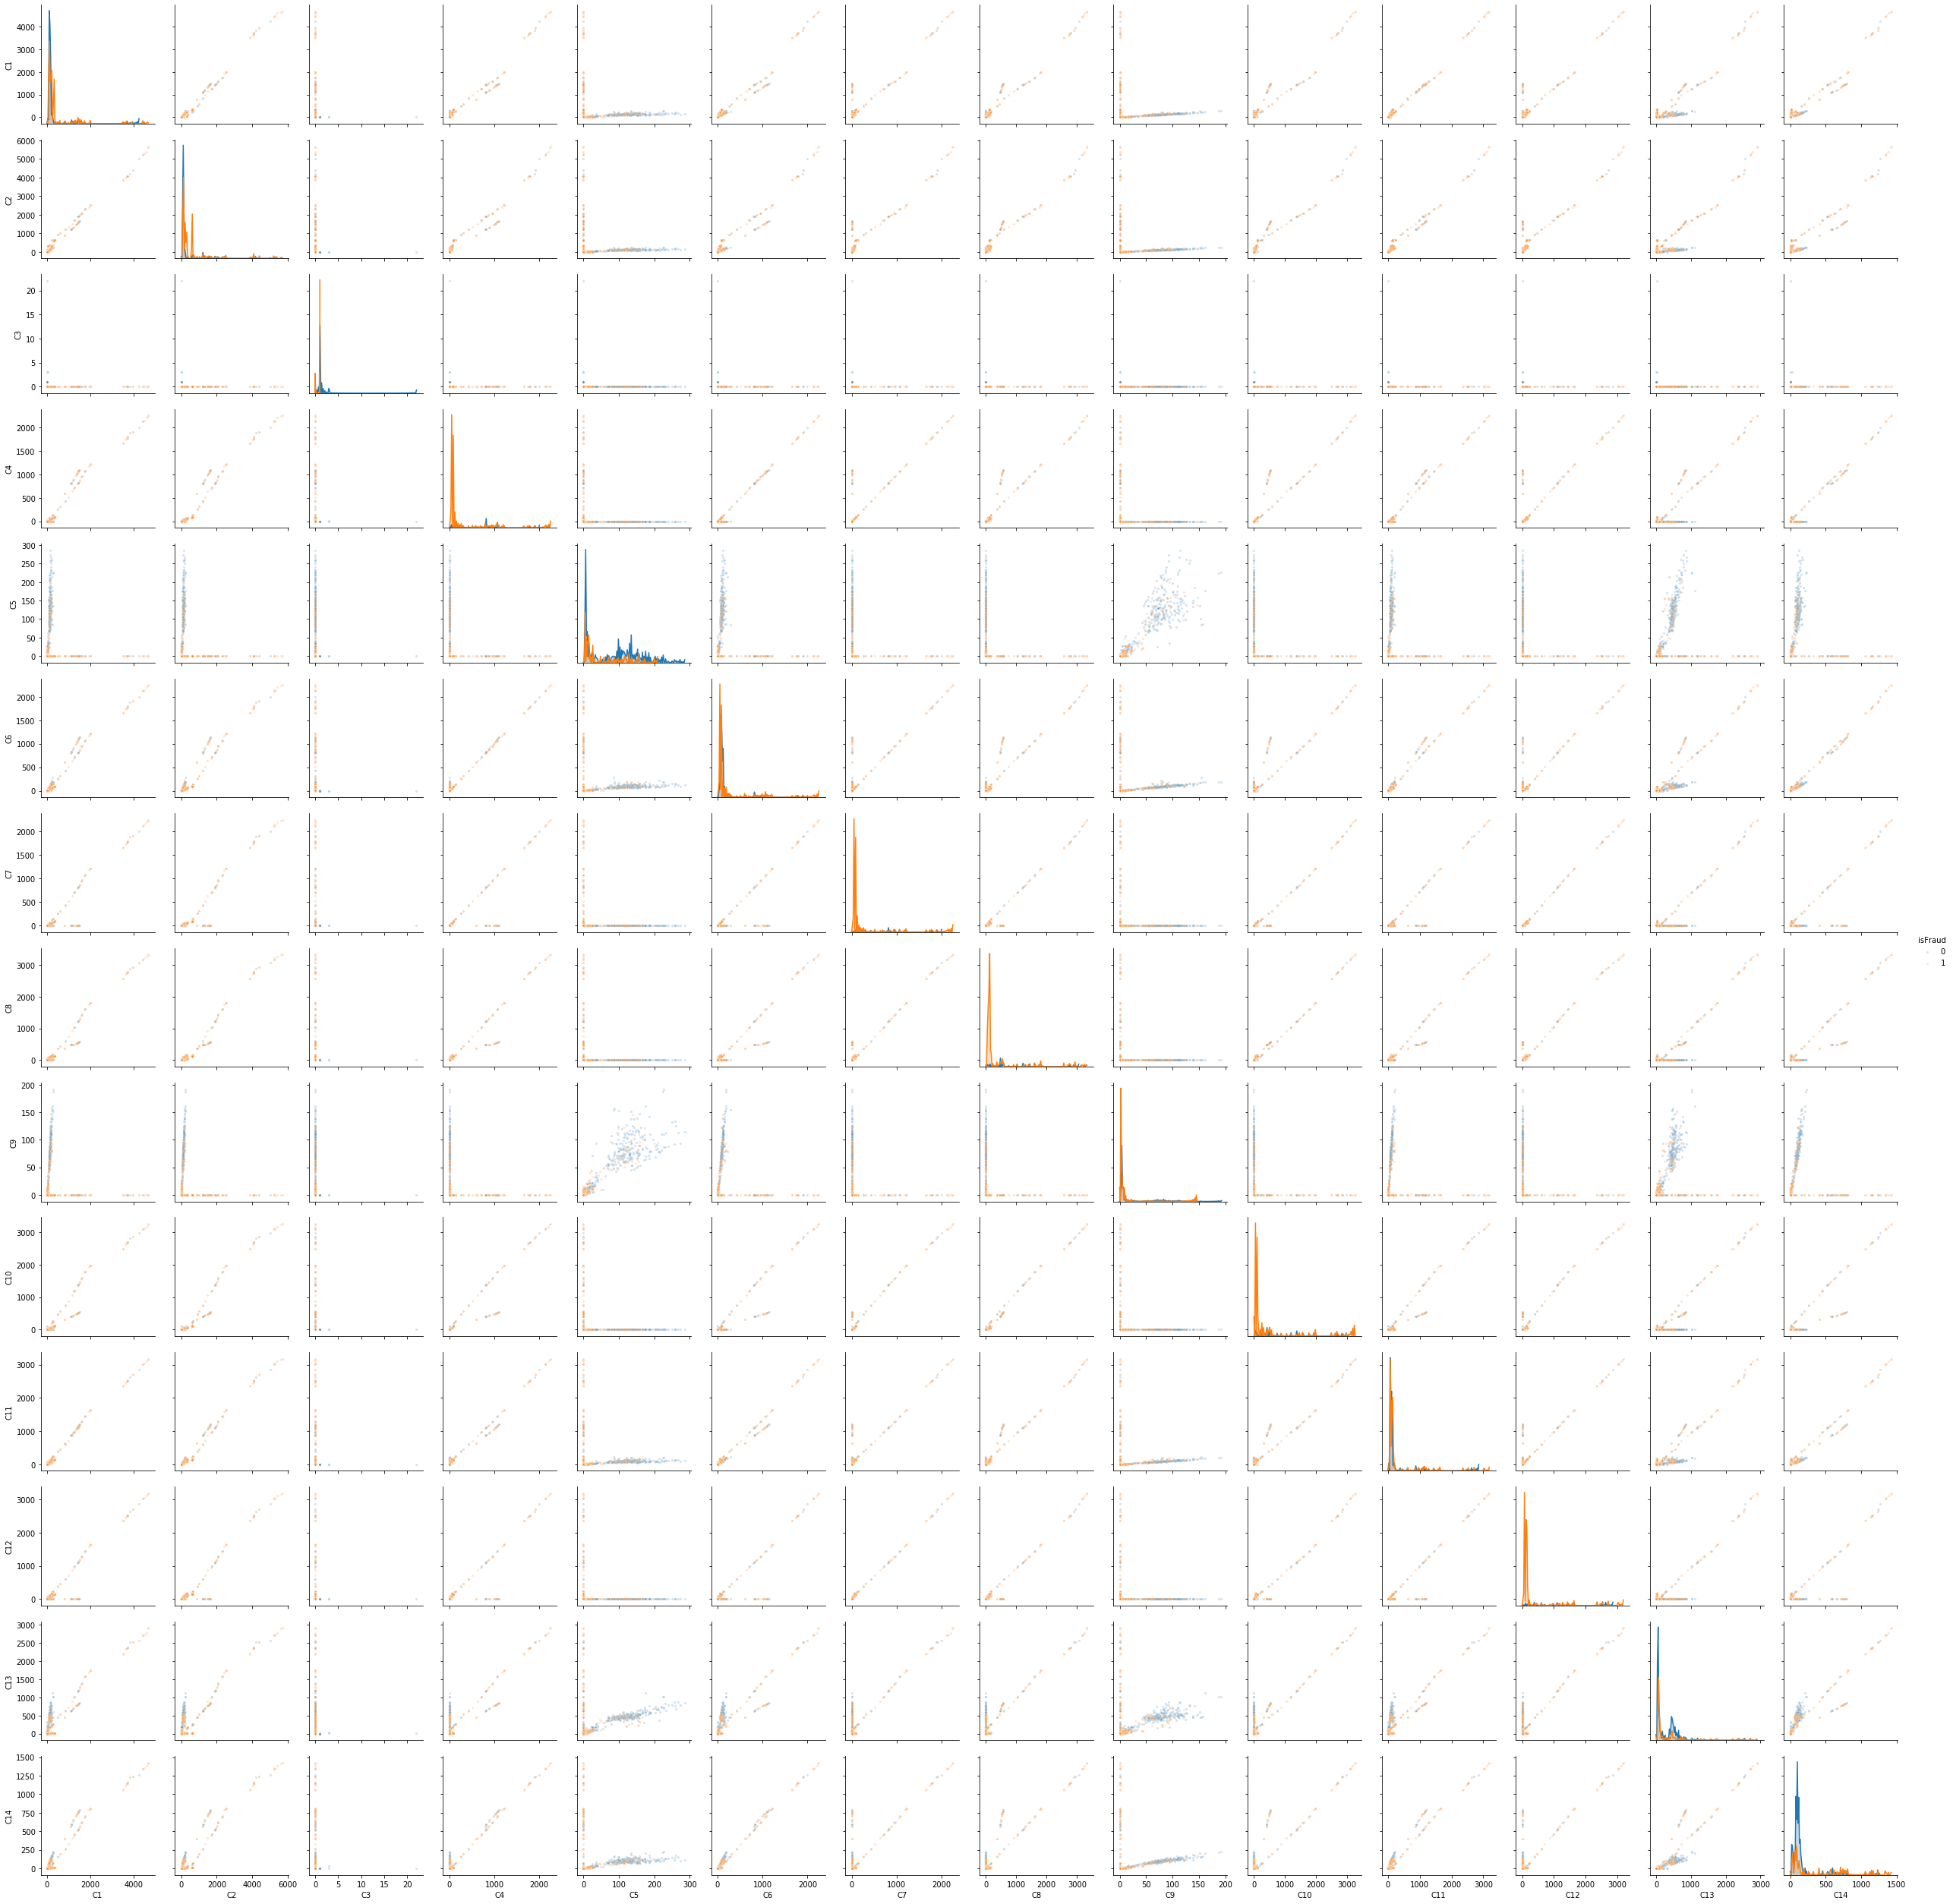

In [17]:
sns.pairplot(
    sampled_train[['isFraud']+c_cols], 
    hue='isFraud',
    vars=c_cols,
    #plot_kws=dict(s=50, edgecolor="b", linewidth=1)
    plot_kws=dict(s=10, alpha=0.2)
)
plt.show()